In [3]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt
import seaborn as sns

# Thư viện để xử lý các text entry
import fuzzywuzzy
from fuzzywuzzy import process

# Thư viện xây dựng mô hình học máy
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Utils
from tqdm import tqdm
import missingno as msno
import optuna

# Thư viện dùng để ẩn các warnings
import warnings
warnings.filterwarnings('ignore')

# Config

In [4]:
# Xử lý các giá trị bị sai chính tả

def replace_matches_in_column(df, column, string_to_match, min_ratio):
    strings = df[column].unique()
    matches = fuzzywuzzy.process.extract(string_to_match, strings, 
                                         limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

    # only get matches with a ratio > min_ratio
    # matches[1:] because maches[0] alawys = (string_to_match, 100)
    close_matches = [matches[0] for matches in matches[1:] if matches[1] >= min_ratio]

    # get the rows of all the close matches in our dataframe
    rows_with_matches = df[column].isin(close_matches)
    for index, row in df[rows_with_matches].iterrows():
        print(index, row[column], '->', string_to_match)

    # replace all rows with close matches with the input matches 
    df.loc[rows_with_matches, column] = string_to_match

In [5]:
# Extract index and value from a pandas series

def extract_idx_value(pd_series):
    idx = pd_series.index
    value = pd_series.values
    return idx, value

In [6]:
# Custom Classifier

class Classifier:
    
    def __init__(self, n_fold=5):
        self.classifiers = {
            'Linear Model': LinearRegression(),
            'Decision Tree': DecisionTreeRegressor(random_state=42),
            'KNN': KNeighborsRegressor(),
            'Random Forest': RandomForestRegressor(random_state=42),
            'XGBoost': XGBRegressor(random_state=42, tree_method='gpu_hist', enable_categorical=True),
            'LightGBM': LGBMRegressor(random_state=42, device='gpu'),
            'CatBoost': CatBoostRegressor(random_state=42, verbose=False, task_type='GPU')
        }
        self.n_fold = n_fold

        self.scores_rmse = {key: 0 for key in self.classifiers.keys()}
        self.std_rmse = {key: 0 for key in self.classifiers.keys()}
        self.scores_mae = {key: 0 for key in self.classifiers.keys()}
        self.std_mae = {key: 0 for key in self.classifiers.keys()}
    
    def fit(self, X, y):
        kf = KFold(n_splits=self.n_fold)
        for classifier in tqdm(self.classifiers):
            scores_rmse = []
            scores_mae = []
            for train_index, val_index in kf.split(X, y):
                X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                X_val, y_val = X.iloc[val_index], y.iloc[val_index]

                self.classifiers[classifier].fit(X_train, y_train)

                y_pred = self.classifiers[classifier].predict(X_val)
                scores_rmse.append(mean_squared_error(y_val, y_pred, squared=False))
                scores_mae.append(mean_squared_error(y_val, y_pred, squared=True))

            self.scores_rmse[classifier] = np.mean(scores_rmse)
            self.std_rmse[classifier] = np.std(scores_rmse)

            self.scores_mae[classifier] = np.mean(scores_mae)
            self.std_mae[classifier] = np.std(scores_mae)
            
    def summary(self):
        return pd.DataFrame({
            'Score RMSE': self.scores_rmse,
            'Std RMSE': self.std_rmse,
            'Score MAE': self.scores_mae,
            'Std MAE': self.std_mae
        })

In [164]:
pd.set_option('display.float_format', lambda x: '%.9f' % x)
pd.set_option('display.max_rows', 500)

In [8]:
DATA_PATH = 'VN_housing_dataset.csv'

In [9]:
# Load dữ liệu và xem vài dòng đầu tiên của data.

df = pd.read_csv(DATA_PATH)
df.head()

Unnamed: 0        Ngày                                            Địa chỉ  \
0 0.000000000  2020-08-05  Đường Hoàng Quốc Việt, Phường Nghĩa Đô, Quận C...   
1 1.000000000  2020-08-05  Đường Kim Giang, Phường Kim Giang, Quận Thanh ...   
2 2.000000000  2020-08-05  phố minh khai, Phường Minh Khai, Quận Hai Bà T...   
3 3.000000000  2020-08-05  Đường Võng Thị, Phường Thụy Khuê, Quận Tây Hồ,...   
4 4.000000000  2020-08-05  Đường Kim Giang, Phường Kim Giang, Quận Thanh ...   

                Quận             Huyện        Loại hình nhà ở Giấy tờ pháp lý  \
0      Quận Cầu Giấy   Phường Nghĩa Đô           Nhà ngõ, hẻm        Đã có sổ   
1    Quận Thanh Xuân  Phường Kim Giang  Nhà mặt phố, mặt tiền             NaN   
2  Quận Hai Bà Trưng  Phường Minh Khai           Nhà ngõ, hẻm        Đã có sổ   
3        Quận Tây Hồ  Phường Thụy Khuê           Nhà ngõ, hẻm        Đã có sổ   
4    Quận Thanh Xuân  Phường Kim Giang           Nhà ngõ, hẻm             NaN   

  Số tầng Số phòng ngủ Diện tích      Dài Rộng           Giá/m2  
0       4      5 phòng     46 m²      NaN  NaN   86,96 triệu/m²  
1     NaN      3 phòng     37 m²      NaN  NaN  116,22 triệu/m²  
2       4      4 phòng     40 m²     10 m  4 m      65 triệu/m²  
3     NaN      6 phòng     51 m²  12.75 m  4 m     100 triệu/m²  
4     NaN      4 phòng     36 m²      9 m  4 m   86,11 triệu/m²

In [10]:
# Xem thông tin của data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82497 entries, 0 to 82496
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       82496 non-null  float64
 1   Ngày             82496 non-null  object 
 2   Địa chỉ          82449 non-null  object 
 3   Quận             82495 non-null  object 
 4   Huyện            82449 non-null  object 
 5   Loại hình nhà ở  82465 non-null  object 
 6   Giấy tờ pháp lý  53610 non-null  object 
 7   Số tầng          36399 non-null  object 
 8   Số phòng ngủ     82458 non-null  object 
 9   Diện tích        82495 non-null  object 
 10  Dài              19827 non-null  object 
 11  Rộng             35445 non-null  object 
 12  Giá/m2           82484 non-null  object 
dtypes: float64(1), object(12)
memory usage: 8.2+ MB


In [11]:
# Drop các dòng bị trùng

df.drop_duplicates(inplace=True)

In [12]:
# Drop các dòng missing toàn bộ

df.dropna(axis=0, how='all', inplace=True)

In [13]:
# Drop các dòng bị missing 'Giá/m2'

df.dropna(axis=0, subset=['Giá/m2'], inplace=True)

In [14]:
# Drop cột Unnamed: 0

df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [15]:
# Đổi tên cột 'Huyện' thành 'Phường'

df.rename(columns={'Huyện': 'Phường'}, inplace=True)

In [16]:
# Reset index

df.reset_index(drop=True, inplace=True)

# EDA

## Xử lý missing data

In [17]:
# Số lượng các giá trị bị thiếu trong mỗi cột

df.isna().sum()

Ngày                   0
Địa chỉ               47
Quận                   1
Phường                47
Loại hình nhà ở       31
Giấy tờ pháp lý    28882
Số tầng            46089
Số phòng ngủ          38
Diện tích              0
Dài                62661
Rộng               47045
Giá/m2                 0
dtype: int64

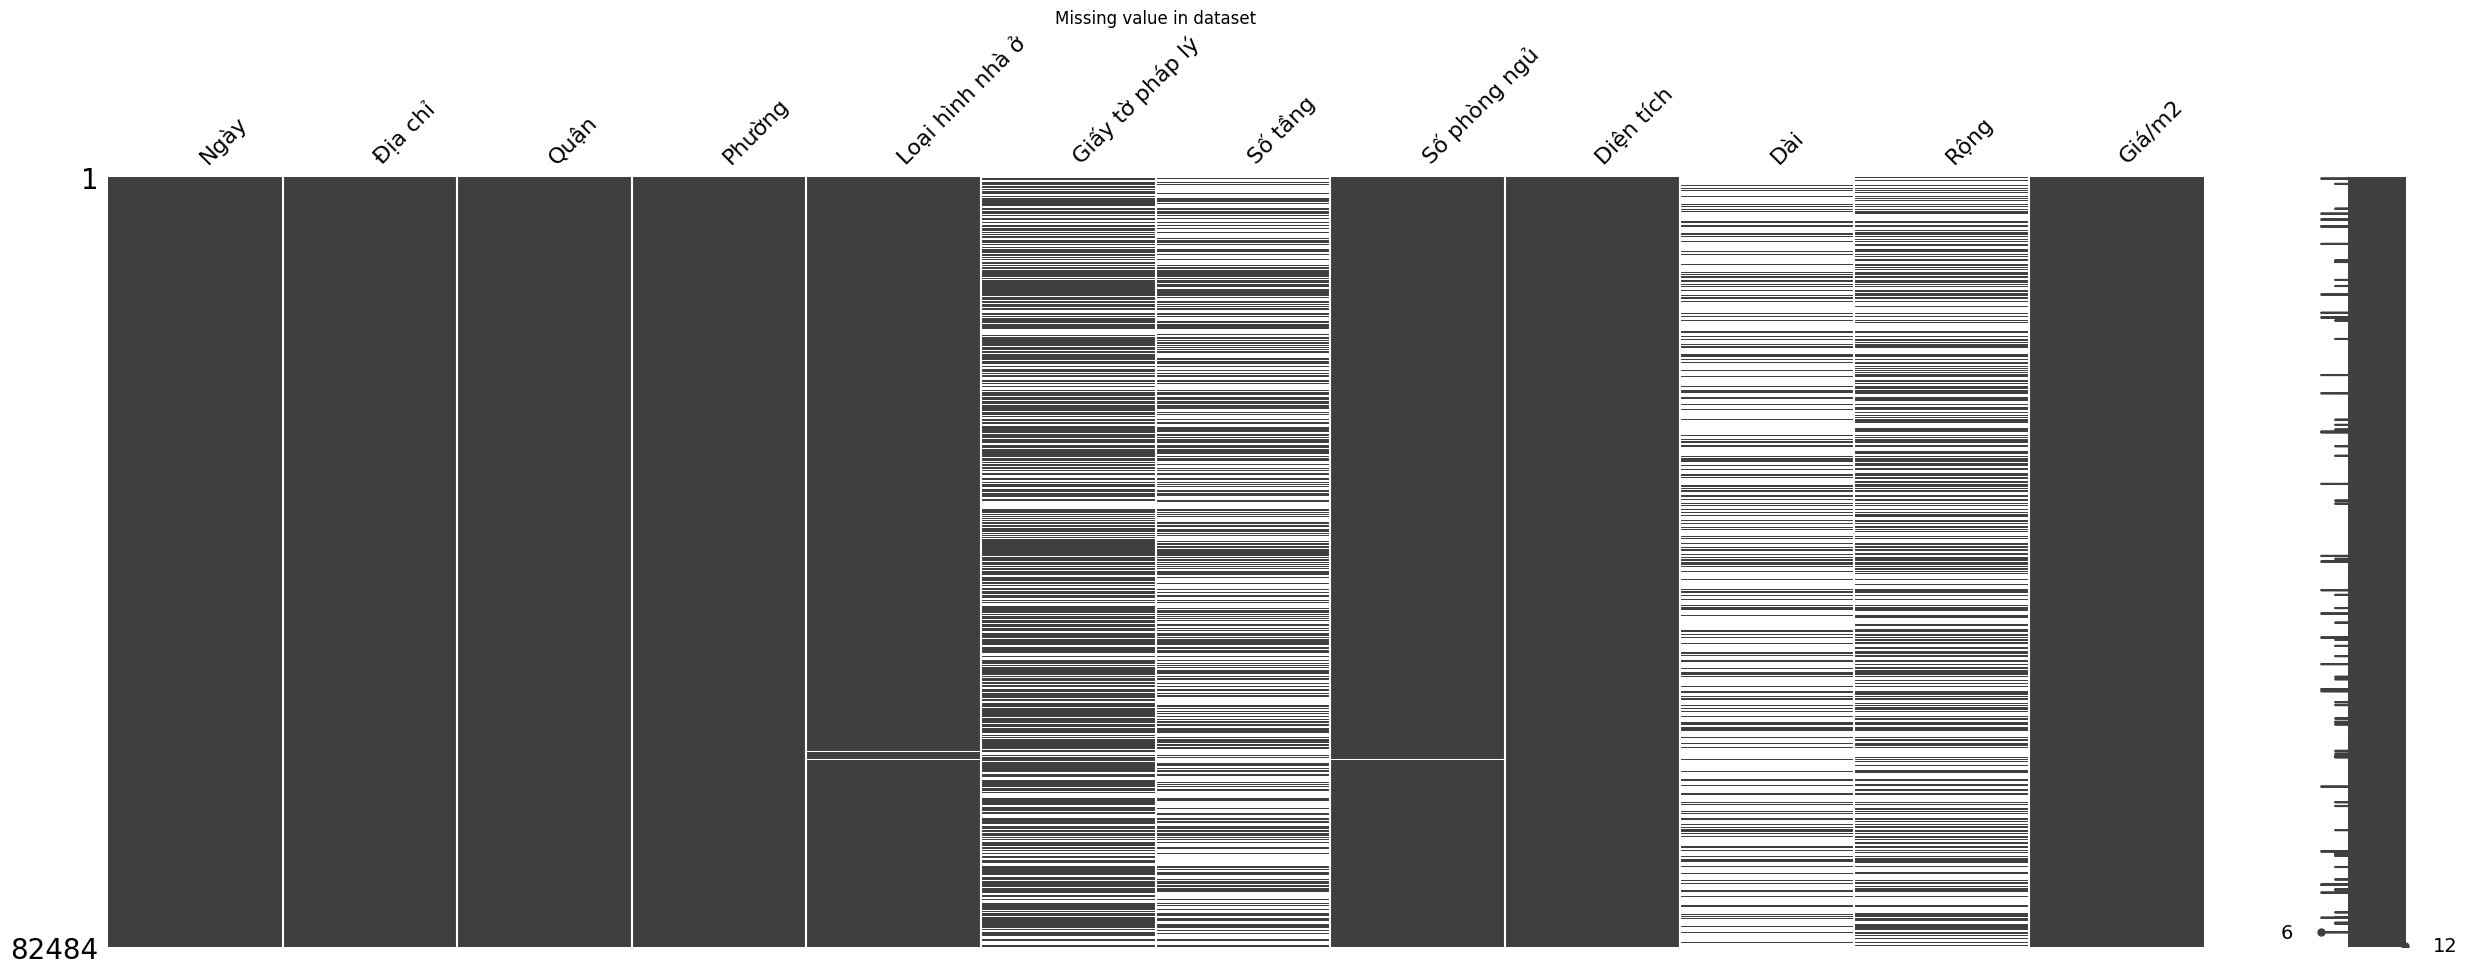

In [18]:
msno.matrix(df, figsize = (30,10))
plt.title('Missing value in dataset')
plt.show()

In [19]:
# Tỉ lệ giá trị NaN trong mỗi cột

ratio_nan_per_col = df.isna().sum() / len(df) * 100
ratio_nan_per_col

Ngày               0.000000000
Địa chỉ            0.056980748
Quận               0.001212356
Phường             0.056980748
Loại hình nhà ở    0.037583046
Giấy tờ pháp lý   35.015275690
Số tầng           55.876291159
Số phòng ngủ       0.046069541
Diện tích          0.000000000
Dài               75.967460356
Rộng              57.035303816
Giá/m2             0.000000000
dtype: float64

### Cột 'Quận'

In [20]:
# Các dòng dữ liệu bị missing ở cột 'Quận'

df[df['Quận'].isna()]

Ngày               Địa chỉ Quận Phường Loại hình nhà ở  \
48416  2020-07-03  68, Ngọc Hồi, Hà Nội  NaN    NaN    Nhà ngõ, hẻm   

      Giấy tờ pháp lý Số tầng Số phòng ngủ Diện tích  Dài Rộng       Giá/m2  
48416        Đã có sổ     NaN      2 phòng     71 m²  6 m  6 m  43 triệu/m²

68 Ngọc Hồi thuộc Phường Hoàng Liệt, Quận Hoàng Mai

In [21]:
df.loc[df[df['Quận'].isna()].index, ['Quận', 'Phường']] = ['Quận Hoàng Mai', 'Phường Hoàng Liệt']

### Cột 'Phường'

In [22]:
# Các dòng dữ liệu bị missing ở cột 'Phường'

df[df['Phường'].isna()]

Ngày                                          Địa chỉ  \
174    2020-08-04                                              NaN   
324    2020-08-04        Đường An Dương Vương, Quận Tây Hồ, Hà Nội   
741    2020-08-04               Cầu Khê Tang, Quận Hà Đông, Hà Nội   
4558   2020-08-03                                              NaN   
5282   2020-08-02                                              NaN   
5295   2020-08-02                                              NaN   
7169   2020-08-01                                              NaN   
8583   2020-07-31                                              NaN   
12594  2020-07-29                                              NaN   
14547  2020-07-28                                              NaN   
15054  2020-07-28                                              NaN   
21213  2020-07-23                                              NaN   
23167  2020-07-22                                              NaN   
27281  2020-07-20                                              NaN   
27348  2020-07-20                                              NaN   
29299  2020-07-18            Đường Cầu Giấy, Quận Cầu Giấy, Hà Nội   
32880  2020-07-15                                              NaN   
35552  2020-07-14          Đường Thịnh Hào 3, Quận Đống Đa, Hà Nội   
40592  2020-07-09                                              NaN   
40905  2020-07-09         Đường Kim Giang, Quận Thanh Xuân, Hà Nội   
41191  2020-07-09                                              NaN   
44260  2020-07-07                                              NaN   
46174  2020-07-06            Đường Cầu Giấy, Quận Cầu Giấy, Hà Nội   
46763  2020-07-05                                              NaN   
49336  2020-07-03                                              NaN   
52183  2020-07-01     Trung Kính - Cầu Giấy, Quận Cầu Giấy, Hà Nội   
54423  2020-06-29       Đường Trần Duy Hưng, Quận Cầu Giấy, Hà Nội   
54855  2020-06-28                                              NaN   
55083  2020-06-28                                              NaN   
58637  2020-06-25   Đường Bùi Xương Trạch, Quận Thanh Xuân, Hà Nội   
61774  2020-06-23        Đường Tôn Thất Tùng, Quận Đống Đa, Hà Nội   
62052  2020-06-22    Đường Hồ Tùng Mậu||821, Quận Cầu Giấy, Hà Nội   
65306  2020-06-19                                              NaN   
69467  2020-06-17              Đường Hào Nam, Quận Đống Đa, Hà Nội   
70511  2020-06-16             Đường Ngọc Lâm, Quận Ba Đình, Hà Nội   
72244  2020-06-15                                              NaN   
72721  2020-06-14       665, Đường Tân Mai, Quận Hoàng Mai, Hà Nội   
73912  2020-06-12         Đường Lạc Long Quân, Quận Tây Hồ, Hà Nội   
75807  2020-06-11           Hà Đông , Hà Nội, Quận Hà Đông, Hà Nội   
75812  2020-06-11                                              NaN   
76659  2020-06-10                                              NaN   
78768  2020-06-09          Đường Hoàng Mai, Quận Hoàng Mai, Hà Nội   
79348  2020-06-08  Trần Duy Hưng - Cầu Giấy, Quận Cầu Giấy, Hà Nội   
79985  2020-06-08    Đường Hoàng Văn Thái, Quận Thanh Xuân, Hà Nội   
80906  2020-06-07                                              NaN   
81021  2020-06-07       Đường Chợ Khâm Thiên, Quận Đống Đa, Hà Nội   

                   Quận Phường        Loại hình nhà ở Giấy tờ pháp lý Số tầng  \
174    Quận Nam Từ Liêm    NaN           Nhà ngõ, hẻm             NaN     NaN   
324         Quận Tây Hồ    NaN           Nhà ngõ, hẻm        Đã có sổ       4   
741        Quận Hà Đông    NaN           Nhà ngõ, hẻm             NaN     NaN   
4558     Huyện Hoài Đức    NaN           Nhà ngõ, hẻm             NaN     NaN   
5282     Quận Long Biên    NaN           Nhà ngõ, hẻm             NaN     NaN   
5295     Quận Long Biên    NaN           Nhà ngõ, hẻm             NaN     NaN   
7169    Huyện Thanh Trì    NaN           Nhà ngõ, hẻm             NaN     NaN   
8583    Quận Thanh Xuân    NaN           Nhà ngõ, hẻm        Đã có sổ     

In [23]:
df['Địa chỉ']

0        Đường Hoàng Quốc Việt, Phường Nghĩa Đô, Quận C...
1        Đường Kim Giang, Phường Kim Giang, Quận Thanh ...
2        phố minh khai, Phường Minh Khai, Quận Hai Bà T...
3        Đường Võng Thị, Phường Thụy Khuê, Quận Tây Hồ,...
4        Đường Kim Giang, Phường Kim Giang, Quận Thanh ...
                               ...                        
82479    Đường Hồ Tùng Mậu, Phường Phúc Diễn, Quận Bắc ...
82480    Đường Trần Quốc Hoàn, Phường Quan Hoa, Quận Cầ...
82481    Đường Nguyễn Khánh Toàn, Phường Quan Hoa, Quận...
82482    Đường Quan Hoa, Phường Quan Hoa, Quận Cầu Giấy...
82483    Đường Hồ Tùng Mậu, Phường Mai Dịch, Quận Cầu G...
Name: Địa chỉ, Length: 82484, dtype: object

In [24]:
# Vì ta điền giữ liệu cột Huyện dựa vào cột Địa chỉ nên ta sẽ chỉ chọn các dòng dữ liệu có cột Địa chỉ không bị missing

df[df['Phường'].isna() & ~df['Địa chỉ'].isna()]

Ngày                                          Địa chỉ  \
324    2020-08-04        Đường An Dương Vương, Quận Tây Hồ, Hà Nội   
741    2020-08-04               Cầu Khê Tang, Quận Hà Đông, Hà Nội   
29299  2020-07-18            Đường Cầu Giấy, Quận Cầu Giấy, Hà Nội   
35552  2020-07-14          Đường Thịnh Hào 3, Quận Đống Đa, Hà Nội   
40905  2020-07-09         Đường Kim Giang, Quận Thanh Xuân, Hà Nội   
46174  2020-07-06            Đường Cầu Giấy, Quận Cầu Giấy, Hà Nội   
52183  2020-07-01     Trung Kính - Cầu Giấy, Quận Cầu Giấy, Hà Nội   
54423  2020-06-29       Đường Trần Duy Hưng, Quận Cầu Giấy, Hà Nội   
58637  2020-06-25   Đường Bùi Xương Trạch, Quận Thanh Xuân, Hà Nội   
61774  2020-06-23        Đường Tôn Thất Tùng, Quận Đống Đa, Hà Nội   
62052  2020-06-22    Đường Hồ Tùng Mậu||821, Quận Cầu Giấy, Hà Nội   
69467  2020-06-17              Đường Hào Nam, Quận Đống Đa, Hà Nội   
70511  2020-06-16             Đường Ngọc Lâm, Quận Ba Đình, Hà Nội   
72721  2020-06-14       665, Đường Tân Mai, Quận Hoàng Mai, Hà Nội   
73912  2020-06-12         Đường Lạc Long Quân, Quận Tây Hồ, Hà Nội   
75807  2020-06-11           Hà Đông , Hà Nội, Quận Hà Đông, Hà Nội   
78768  2020-06-09          Đường Hoàng Mai, Quận Hoàng Mai, Hà Nội   
79348  2020-06-08  Trần Duy Hưng - Cầu Giấy, Quận Cầu Giấy, Hà Nội   
79985  2020-06-08    Đường Hoàng Văn Thái, Quận Thanh Xuân, Hà Nội   
81021  2020-06-07       Đường Chợ Khâm Thiên, Quận Đống Đa, Hà Nội   

                  Quận Phường        Loại hình nhà ở Giấy tờ pháp lý Số tầng  \
324        Quận Tây Hồ    NaN           Nhà ngõ, hẻm        Đã có sổ       4   
741       Quận Hà Đông    NaN           Nhà ngõ, hẻm             NaN     NaN   
29299    Quận Cầu Giấy    NaN           Nhà ngõ, hẻm        Đã có sổ       4   
35552     Quận Đống Đa    NaN           Nhà ngõ, hẻm        Đã có sổ     NaN   
40905  Quận Thanh Xuân    NaN  Nhà mặt phố, mặt tiền             NaN     NaN   
46174    Quận Cầu Giấy    NaN           Nhà ngõ, hẻm             NaN     NaN   
52183    Quận Cầu Giấy    NaN                    NaN             NaN     NaN   
54423    Quận Cầu Giấy    NaN           Nhà ngõ, hẻm        Đã có sổ       5   
58637  Quận Thanh Xuân    NaN           Nhà ngõ, hẻm             NaN     NaN   
61774     Quận Đống Đa    NaN           Nhà ngõ, hẻm             NaN     NaN   
62052    Quận Cầu Giấy    NaN           Nhà ngõ, hẻm        Đã có sổ       5   
69467     Quận Đống Đa    NaN           Nhà ngõ, hẻm        Đã có sổ     NaN   
70511     Quận Ba Đình    NaN  Nhà mặt phố, mặt tiền        Đã có sổ     NaN   
72721   Quận Hoàng Mai    NaN           Nhà ngõ, hẻm             NaN     NaN   
73912      Quận Tây Hồ    NaN  Nhà mặt phố, mặt tiền             NaN     NaN   
75807     Quận Hà Đông    NaN                    NaN             NaN     NaN   
78768   Quận Hoàng Mai    NaN           Nhà ngõ, hẻm             NaN     NaN   
79348    Quận Cầu Giấy    NaN                    NaN             NaN     NaN   
79985  Quận Thanh Xuân    NaN  Nhà mặt phố, mặt tiền             NaN     NaN   
81021     Quận Đống Đa    NaN           Nhà ngõ, hẻm        Đã có sổ       3   

      Số phòng ngủ Diện tích   Dài  Rộng           Giá/m2  
324        4 phòng     77 m²  11 m   7 m    97,4 triệu/m²  
741        3 phòng     36 m²   NaN   NaN   43,06 triệu/m²  
29299      3 phòng     24 m²   NaN   NaN  129,17 triệu/m²  
35552      6 phòng     36 m²   NaN   NaN     100 triệu/m²  
40905      4 phòng     40 m²   NaN   NaN    82,5 triệu/m²  
46174      4 phòng     50 m²   NaN   NaN      80 triệu/m²  
52183      3 phòng     36 m²   NaN   NaN   80,56 triệu/m²  
54423      4 phòng     40 m²   NaN   NaN     140 triệu/m²  
58637      3 phòng     31 m²   NaN   NaN  116,13 triệu/m²  
61774      3 phòng     37 m²   NaN   NaN  110,81 triệu/m²  
62052      4 phòng     33 m²  10 m   4 m   96,97 triệu/m²  
69467      3 phòng     35 m²   NaN   NaN   91,43 triệu/m²  
70511      4 phòng     51 m²   NaN   NaN   94,12 triệu/m²  
72721      6 phòng   

Do khó xác định chính xác địa chỉ nên ta sẽ điền giá trị Phường bị missing với giá trị mode phường theo Quận

In [25]:
# Tại index 72730, có địa chỉ 665, Đường Tân Mai, Quận Hoàng Mai, Hà Nội => Phường Hoàng Văn Thụ, Quận Hoàng Mai, Hà Nội

df.loc[72730, 'Phường'] = 'Phường Hoàng Văn Thụ'

In [26]:
# Một số Quận có mode là 2 phường, do đó ta sẽ lấy phường đầu tiên làm mode

df_mode_phuong = df.groupby('Quận')['Phường'].agg(
    { lambda x: x.mode()[0] }
)
df_mode_phuong.head()

<lambda>
Quận                                
Huyện Ba Vì               Xã Vân Hòa
Huyện Chương Mỹ    Thị trấn Xuân Mai
Huyện Gia Lâm      Thị trấn Trâu Quỳ
Huyện Hoài Đức           Xã Vân Canh
Huyện Mê Linh    Thị trấn Quang Minh

In [27]:
for index, row in df[df['Phường'].isna()].iterrows():
    df.loc[index, 'Phường'] = df_mode_phuong.loc[row['Quận']][0]

### Cột 'Địa chỉ'

In [28]:
# Do ta đã có cột 'Quận', 'Phường', do vậy ta có thể drop cột 'Địa chỉ'

df.drop(['Địa chỉ'], axis=1, inplace=True)

### Cột 'Loại hình nhà ở'

In [29]:
df[df['Loại hình nhà ở'].isna()]

Ngày              Quận                 Phường Loại hình nhà ở  \
3928   2020-08-03       Quận Tây Hồ        Phường Quảng An             NaN   
19887  2020-07-24      Quận Hà Đông         Phường Phúc La             NaN   
23414  2020-07-22       Quận Tây Hồ         Phường Xuân La             NaN   
26556  2020-07-20      Quận Đống Đa         Phường Láng Hạ             NaN   
26907  2020-07-20  Quận Nam Từ Liêm          Phường Đại Mỗ             NaN   
27057  2020-07-20      Quận Đống Đa       Phường Ô Chợ Dừa             NaN   
29869  2020-07-17      Quận Đống Đa       Phường Ô Chợ Dừa             NaN   
34666  2020-07-14      Quận Hà Đông          Phường Hà Cầu             NaN   
34995  2020-07-14      Quận Hà Đông          Phường La Khê             NaN   
47740  2020-07-04  Quận Nam Từ Liêm       Phường Mỹ Đình 2             NaN   
51995  2020-07-01    Thị xã Sơn Tây             Xã Cổ Đông             NaN   
52183  2020-07-01     Quận Cầu Giấy         Phường Yên Hoà             NaN   
53542  2020-06-29    Quận Long Biên           Phường Bồ Đề             NaN   
53799  2020-06-29      Quận Hà Đông          Phường Hà Cầu             NaN   
56568  2020-06-26      Quận Hà Đông        Phường Văn Quán             NaN   
57999  2020-06-25      Quận Hà Đông          Phường Hà Cầu             NaN   
58364  2020-06-25   Quận Thanh Xuân  Phường Thanh Xuân Nam             NaN   
58415  2020-06-25      Quận Ba Đình      Phường Ngọc Khánh             NaN   
61541  2020-06-23    Quận Hoàng Mai         Phường Đại Kim             NaN   
61948  2020-06-23      Quận Hà Đông         Phường Phúc La             NaN   
62031  2020-06-22      Quận Hà Đông       Phường Kiến Hưng             NaN   
62040  2020-06-22      Quận Hà Đông        Phường Văn Quán             NaN   
62398  2020-06-22    Huyện Hoài Đức            Xã Di Trạch             NaN   
66969  2020-06-18     Quận Cầu Giấy        Phường Quan Hoa             NaN   
69960  2020-06-16      Quận Hà Đông       Phường Dương Nội             NaN   
75735  2020-06-11     Quận Cầu Giấy       Phường Dịch Vọng             NaN   
75807  2020-06-11      Quận Hà Đông        Phường Văn Quán             NaN   
76382  2020-06-10      Quận Hà Đông       Phường Dương Nội             NaN   
79334  2020-06-08     Quận Cầu Giấy        Phường Nghĩa Đô             NaN   
79348  2020-06-08     Quận Cầu Giấy         Phường Yên Hoà             NaN   
79889  2020-06-08     Quận Cầu Giấy       Phường Nghĩa Tân             NaN   

      Giấy tờ pháp lý Số tầng Số phòng ngủ Diện tích   Dài   Rộng  \
3928              NaN     NaN          NaN   1000 m²   NaN    NaN   
19887        Đã có sổ     NaN      4 phòng     50 m²   NaN    NaN   
23414        Đã có sổ     NaN          NaN     33 m²   9 m  3.6 m   
26556        Đã có sổ     NaN          NaN     71 m²   NaN    NaN   
26907     Đang chờ sổ     NaN      1 phòng     45 m²   NaN    NaN   
27057        Đã có sổ     NaN          NaN     47 m²   NaN    NaN   
29869        Đã có sổ     NaN          NaN     70 m²   NaN    NaN   
34666             NaN     NaN      3 phòng     36 m²   NaN    NaN   
34995             NaN     NaN      4 phòng     50 m²   NaN    NaN   
47740             NaN     NaN      2 phòng     40 m²   NaN    NaN   
51995     Đang chờ sổ     NaN          NaN    117 m²  24 m    5 m   
52183             NaN     NaN      3 phòng     36 m²   NaN    NaN   
53542        Đã có sổ     NaN          NaN     50 m²   NaN    NaN   
53799             NaN     NaN      4 phòng     38 m²   NaN    NaN   
56568        Đã có sổ     NaN          NaN     40 m²   NaN    NaN   
57999             NaN     NaN      3 phòng     38 m²   NaN    NaN   
58364             NaN     NaN      4 phòng     40 m²   NaN    NaN   
58415        Đã có sổ     NaN          NaN    120 m²   NaN    NaN   
61541        Đã có sổ     NaN      5 phòng     75 m²   NaN    NaN   
61948        Đã có sổ     NaN      4 phòng    140 m²   NaN    NaN   
62031             NaN     NaN      3 phòng     37 m²   NaN    NaN  

In [30]:
df['Loại hình nhà ở'].value_counts()

Loại hình nhà ở
Nhà ngõ, hẻm             62528
Nhà mặt phố, mặt tiền    17092
Nhà phố liền kề           1881
Nhà biệt thự               952
Name: count, dtype: int64

Điền giá trị NaN bằng giá trị mode

In [31]:
df['Loại hình nhà ở'].fillna('Nhà ngõ, hẻm', inplace=True)

### Cột 'Giấy tờ pháp lý'

In [32]:
df['Giấy tờ pháp lý'].value_counts()

Giấy tờ pháp lý
Đã có sổ        52906
Đang chờ sổ       356
Giấy tờ khác      340
Name: count, dtype: int64

In [33]:
df[df['Giấy tờ pháp lý'].isna()]

Ngày              Quận              Phường  \
1      2020-08-05   Quận Thanh Xuân    Phường Kim Giang   
4      2020-08-05   Quận Thanh Xuân    Phường Kim Giang   
6      2020-08-05      Quận Đống Đa   Phường Trung Liệt   
8      2020-08-05       Quận Tây Hồ      Phường Xuân La   
13     2020-08-05      Quận Hà Đông  Phường Quang Trung   
...           ...               ...                 ...   
82474  2019-10-15  Quận Nam Từ Liêm    Phường Mỹ Đình 2   
82475  2019-10-15  Quận Nam Từ Liêm    Phường Mỹ Đình 1   
82479  2019-08-23  Quận Bắc Từ Liêm    Phường Phúc Diễn   
82480  2019-08-07     Quận Cầu Giấy     Phường Quan Hoa   
82483  2019-08-05     Quận Cầu Giấy     Phường Mai Dịch   

             Loại hình nhà ở Giấy tờ pháp lý Số tầng Số phòng ngủ Diện tích  \
1      Nhà mặt phố, mặt tiền             NaN     NaN      3 phòng     37 m²   
4               Nhà ngõ, hẻm             NaN     NaN      4 phòng     36 m²   
6               Nhà ngõ, hẻm             NaN     NaN      3 phòng     52 m²   
8               Nhà ngõ, hẻm             NaN     NaN      4 phòng     75 m²   
13              Nhà ngõ, hẻm             NaN     NaN      5 phòng     50 m²   
...                      ...             ...     ...          ...       ...   
82474  Nhà mặt phố, mặt tiền             NaN     NaN      4 phòng     50 m²   
82475           Nhà ngõ, hẻm             NaN     NaN      6 phòng     60 m²   
82479        Nhà phố liền kề             NaN     NaN      3 phòng     38 m²   
82480  Nhà mặt phố, mặt tiền             NaN     NaN      3 phòng     50 m²   
82483        Nhà phố liền kề             NaN     NaN      4 phòng     45 m²   

        Dài   Rộng           Giá/m2  
1       NaN    NaN  116,22 triệu/m²  
4       9 m    4 m   86,11 triệu/m²  
6       NaN  4.5 m   112,5 triệu/m²  
8      12 m  6.5 m     120 triệu/m²  
13      NaN    5 m      86 triệu/m²  
...     ...    ...              ...  
82474   NaN    NaN     106 triệu/m²  
82475   NaN    NaN   91,67 triệu/m²  
82479   NaN    NaN   81,58 triệu/m²  
82480   NaN    NaN     292 triệu/m²  
82483   NaN    NaN  102,22 triệu/m²  

[28882 rows x 11 columns]

In [34]:
# Do số lượng dòng bị missing ở cột 'Giấy tờ pháp lý' lớn, do đó ta sẽ thay thế các giá trị bị missing bằng 'Unknown'

df['Giấy tờ pháp lý'].fillna('Unknown', inplace=True)

### Cột 'Số tầng'

In [35]:
df['Số tầng'].value_counts()

Số tầng
5               15767
4               12277
3                3619
6                2119
2                1028
1                 636
7                 597
8                 188
9                  88
10                 36
45                  8
Nhiều hơn 10        7
35                  6
50                  2
12                  2
38                  2
30                  1
32                  1
54                  1
52                  1
40                  1
14                  1
65                  1
55                  1
73                  1
25                  1
42                  1
33                  1
29                  1
Name: count, dtype: int64

In [36]:
df[df['Số tầng'].isna()]

Ngày              Quận             Phường        Loại hình nhà ở  \
1      2020-08-05   Quận Thanh Xuân   Phường Kim Giang  Nhà mặt phố, mặt tiền   
3      2020-08-05       Quận Tây Hồ   Phường Thụy Khuê           Nhà ngõ, hẻm   
4      2020-08-05   Quận Thanh Xuân   Phường Kim Giang           Nhà ngõ, hẻm   
5      2020-08-05     Quận Cầu Giấy     Phường Yên Hoà           Nhà ngõ, hẻm   
6      2020-08-05      Quận Đống Đa  Phường Trung Liệt           Nhà ngõ, hẻm   
...           ...               ...                ...                    ...   
82479  2019-08-23  Quận Bắc Từ Liêm   Phường Phúc Diễn        Nhà phố liền kề   
82480  2019-08-07     Quận Cầu Giấy    Phường Quan Hoa  Nhà mặt phố, mặt tiền   
82481  2019-08-07     Quận Cầu Giấy    Phường Quan Hoa  Nhà mặt phố, mặt tiền   
82482  2019-08-05     Quận Cầu Giấy    Phường Quan Hoa           Nhà ngõ, hẻm   
82483  2019-08-05     Quận Cầu Giấy    Phường Mai Dịch        Nhà phố liền kề   

      Giấy tờ pháp lý Số tầng        Số phòng ngủ Diện tích      Dài   Rộng  \
1             Unknown     NaN             3 phòng     37 m²      NaN    NaN   
3            Đã có sổ     NaN             6 phòng     51 m²  12.75 m    4 m   
4             Unknown     NaN             4 phòng     36 m²      9 m    4 m   
5            Đã có sổ     NaN  nhiều hơn 10 phòng     46 m²   12.1 m  3.8 m   
6             Unknown     NaN             3 phòng     52 m²      NaN  4.5 m   
...               ...     ...                 ...       ...      ...    ...   
82479         Unknown     NaN             3 phòng     38 m²      NaN    NaN   
82480         Unknown     NaN             3 phòng     50 m²      NaN    NaN   
82481        Đã có sổ     NaN             4 phòng     41 m²      NaN    NaN   
82482        Đã có sổ     NaN             4 phòng     60 m²      NaN    NaN   
82483         Unknown     NaN             4 phòng     45 m²      NaN    NaN   

                Giá/m2  
1      116,22 triệu/m²  
3         100 triệu/m²  
4       86,11 triệu/m²  
5      104,35 triệu/m²  
6       112,5 triệu/m²  
...                ...  
82479   81,58 triệu/m²  
82480     292 triệu/m²  
82481  341,46 triệu/m²  
82482  101,67 triệu/m²  
82483  102,22 triệu/m²  

[46089 rows x 11 columns]

In [37]:
# Do số lượng dòng bị missing ở cột 'Số tầng' lớn, do đó ta sẽ thay thế các giá trị bị missing bằng 'Unknown'

df['Số tầng'].fillna('Unknown', inplace=True)

### Cột 'Số phòng ngủ'

In [38]:
df['Số phòng ngủ'].value_counts()

Số phòng ngủ
4 phòng               29068
3 phòng               27156
5 phòng                7923
2 phòng                7329
6 phòng                6461
1 phòng                1388
8 phòng                 938
nhiều hơn 10 phòng      868
7 phòng                 678
10 phòng                354
9 phòng                 283
Name: count, dtype: int64

In [39]:
df[df['Số phòng ngủ'].isna()]

Ngày               Quận                Phường  \
3928   2020-08-03        Quận Tây Hồ       Phường Quảng An   
5478   2020-08-02     Quận Long Biên      Phường Việt Hưng   
13982  2020-07-28   Quận Bắc Từ Liêm      Phường Xuân Đỉnh   
21173  2020-07-23       Quận Đống Đa     Phường Phương Mai   
23414  2020-07-22        Quận Tây Hồ        Phường Xuân La   
26285  2020-07-20     Quận Hoàng Mai      Phường Vĩnh Hưng   
26556  2020-07-20       Quận Đống Đa        Phường Láng Hạ   
26725  2020-07-20    Quận Thanh Xuân     Phường Khương Mai   
27057  2020-07-20       Quận Đống Đa      Phường Ô Chợ Dừa   
28833  2020-07-18   Quận Bắc Từ Liêm      Phường Cổ Nhuế 1   
29440  2020-07-18       Quận Đống Đa      Phường Ngã Tư Sở   
29869  2020-07-17       Quận Đống Đa      Phường Ô Chợ Dừa   
30915  2020-07-17   Quận Bắc Từ Liêm      Phường Xuân Đỉnh   
32898  2020-07-15      Quận Cầu Giấy       Phường Nghĩa Đô   
33090  2020-07-15   Huyện Đan Phượng        Thị trấn Phùng   
33502  2020-07-15    Quận Thanh Xuân   Phường Khương Trung   
34387  2020-07-14     Quận Hoàng Mai  Phường Hoàng Văn Thụ   
38235  2020-07-11    Huyện Thanh Trì       Xã Tả Thanh Oai   
40936  2020-07-09       Quận Đống Đa    Phường Láng Thượng   
44435  2020-07-07   Quận Nam Từ Liêm      Phường Mỹ Đình 1   
45361  2020-07-06     Quận Long Biên      Phường Long Biên   
49996  2020-07-02     Quận Hoàng Mai         Phường Yên Sở   
51209  2020-07-01      Quận Cầu Giấy  Phường Dịch Vọng Hậu   
51692  2020-07-01  Quận Hai Bà Trưng     Phường Thanh Nhàn   
51995  2020-07-01     Thị xã Sơn Tây            Xã Cổ Đông   
53542  2020-06-29     Quận Long Biên          Phường Bồ Đề   
55874  2020-06-27   Quận Nam Từ Liêm    Phường Xuân Phương   
55972  2020-06-27     Huyện Quốc Oai            Xã Phú Cát   
56260  2020-06-27   Quận Nam Từ Liêm      Phường Mỹ Đình 1   
56568  2020-06-26       Quận Hà Đông       Phường Văn Quán   
56864  2020-06-26       Quận Ba Đình     Phường Ngọc Khánh   
58415  2020-06-25       Quận Ba Đình     Phường Ngọc Khánh   
59545  2020-06-24       Quận Đống Đa      Phường Ngã Tư Sở   
62398  2020-06-22     Huyện Hoài Đức           Xã Di Trạch   
64360  2020-06-20     Quận Hoàng Mai       Phường Giáp Bát   
71638  2020-06-15   Quận Nam Từ Liêm         Phường Phú Đô   
72203  2020-06-15     Quận Hoàng Mai       Phường Lĩnh Nam   
72428  2020-06-14     Quận Hoàng Mai        Phường Tân Mai   

             Loại hình nhà ở Giấy tờ pháp lý  Số tầng Số phòng ngủ Diện tích  \
3928            Nhà ngõ, hẻm         Unknown  Unknown          NaN   1000 m²   
5478   Nhà mặt phố, mặt tiền        Đã có sổ  Unknown          NaN     60 m²   
13982           Nhà ngõ, hẻm        Đã có sổ  Unknown          NaN    100 m²   
21173  Nhà mặt phố, mặt tiền        Đã có sổ  Unknown          NaN     49 m²   
23414           Nhà ngõ, hẻm        Đã có sổ  Unknown          NaN     33 m²   
26285  Nhà mặt phố, mặt tiền        Đã có sổ  Unknown          NaN     72 m²   
26556           Nhà ngõ, hẻm        Đã có sổ  Unknown          NaN     71 m²   
26725           Nhà ngõ, hẻm     Đang chờ sổ  Unknown          NaN     32 m²   
27057           Nhà ngõ, hẻm        Đã có sổ  Unknown          NaN     47 m²   
28833  Nhà mặt phố, mặt tiền         Unknown  Unknown          NaN     54 m²   
29440  Nhà mặt phố, mặt tiền        Đã có sổ  Unknown          NaN     77 m²   
29869           Nhà ngõ, hẻm        Đã có sổ  Unknown          NaN     70 m²   
30915  Nhà mặt phố, mặt tiền        Đã có sổ  Unknown          NaN     32 m²   
32898  Nhà mặt phố, mặt tiền        Đã có sổ  Unknown          NaN     55 m²   
33090  Nhà mặt phố, mặt tiền        Đã có sổ  Unknown          NaN     56 m²   
33502  Nhà mặt phố, mặt tiền        Đã có sổ  Unknown          NaN     25 m²   
34387           Nhà ngõ, hẻm        Đã có sổ  Unknown          NaN     80 m²   
38235  Nhà mặt phố, mặt tiền        Đã có sổ  Unknown          NaN     39 m²   
40936  Nhà mặt phố, mặt tiền        Đã có sổ  Unknown          NaN     38 

In [40]:
# Do số lượng dòng bị missing ở cột 'Số phòng ngủ' nhỏ, nên ta điền các giá trị bị missing bằng mode

df['Số phòng ngủ'].fillna('4 phòng', inplace=True)

### Cột 'Dài' và 'Rộng'

Do đã có cột 'Diện tích', nên cột 'Dài', 'Rộng' không cần thiết

In [41]:
df.drop(['Dài', 'Rộng'], axis=1, inplace=True)

**Dữ liệu đã xử lý xong missing data**

In [42]:
print('Số lượng missing data trong mỗi cột:')
df.isna().sum()

Số lượng missing data trong mỗi cột:


Ngày               0
Quận               0
Phường             0
Loại hình nhà ở    0
Giấy tờ pháp lý    0
Số tầng            0
Số phòng ngủ       0
Diện tích          0
Giá/m2             0
dtype: int64

In [43]:
df.reset_index(drop=True, inplace=True)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82484 entries, 0 to 82483
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Ngày             82484 non-null  object
 1   Quận             82484 non-null  object
 2   Phường           82484 non-null  object
 3   Loại hình nhà ở  82484 non-null  object
 4   Giấy tờ pháp lý  82484 non-null  object
 5   Số tầng          82484 non-null  object
 6   Số phòng ngủ     82484 non-null  object
 7   Diện tích        82484 non-null  object
 8   Giá/m2           82484 non-null  object
dtypes: object(9)
memory usage: 5.7+ MB


## Xử lý kiểu dữ liệu

## Convert cột 'Ngày' sang datetime

In [45]:
df['Ngày'] = pd.to_datetime(df['Ngày'])

In [46]:
df['Ngày'].max()

Timestamp('2020-08-05 00:00:00')

In [47]:
df['Ngày'].min()

Timestamp('2019-08-05 00:00:00')

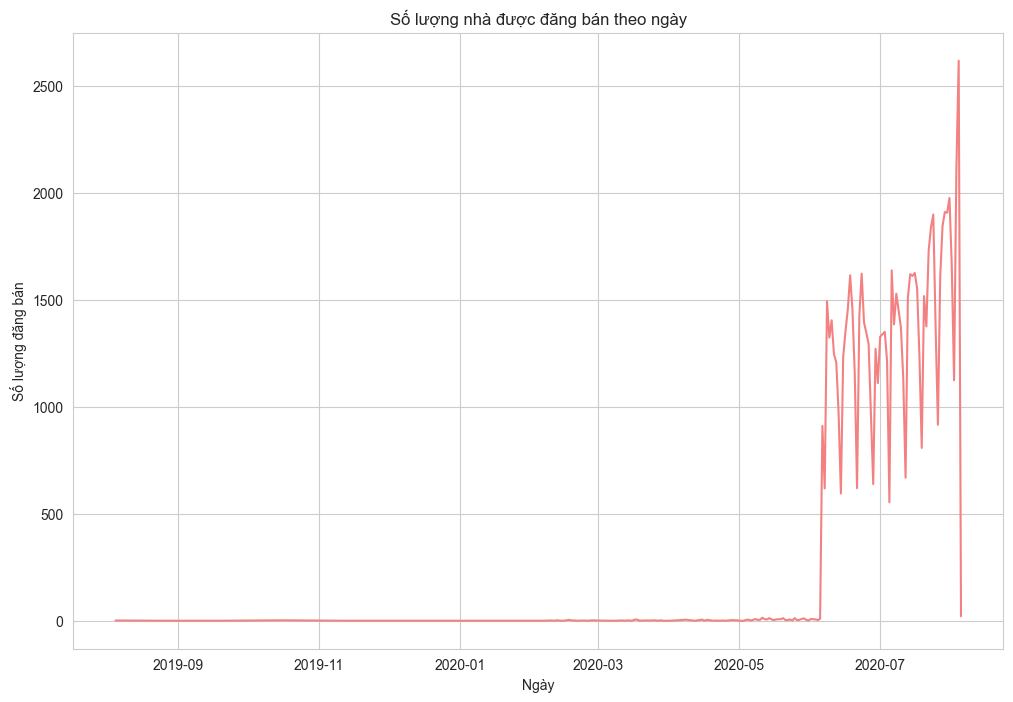

In [247]:
number_house_per_day = df['Ngày'].value_counts(sort=False).iloc[::-1]  # sort=False để giữ nguyên thứ tự ngày, iloc[::-1] để đảo ngược thứ tự
plt.figure(figsize=(12, 8))
plt.plot(number_house_per_day, color='#F38181')
plt.title('Số lượng nhà được đăng bán theo ngày')
plt.xlabel('Ngày')
plt.ylabel('Số lượng đăng bán')
plt.show()

### Cột 'Quận'

In [49]:
df['Quận'].unique()

array(['Quận Cầu Giấy', 'Quận Thanh Xuân', 'Quận Hai Bà Trưng',
       'Quận Tây Hồ', 'Quận Đống Đa', 'Quận Hà Đông', 'Huyện Thanh Trì',
       'Quận Hoàng Mai', 'Quận Long Biên', 'Quận Hoàn Kiếm',
       'Quận Nam Từ Liêm', 'Quận Ba Đình', 'Huyện Hoài Đức',
       'Quận Bắc Từ Liêm', 'Huyện Đan Phượng', 'Huyện Thanh Oai',
       'Huyện Sóc Sơn', 'Huyện Gia Lâm', 'Huyện Chương Mỹ',
       'Huyện Đông Anh', 'Huyện Thường Tín', 'Thị xã Sơn Tây',
       'Huyện Mê Linh', 'Huyện Thạch Thất', 'Huyện Quốc Oai',
       'Huyện Phúc Thọ', 'Huyện Phú Xuyên', 'Huyện Ba Vì', 'Huyện Mỹ Đức'],
      dtype=object)

In [50]:
# Replace các giá trị bị sai chính tả nếu khớp 98% trở lên

for quan in df['Quận'].unique():
    replace_matches_in_column(df=df, column='Quận', string_to_match=quan, min_ratio=98)

print('Done!')

Done!


***Normial category***

Chuyển data-type của 'Quận' sang 'category'.

Nếu các giá trị của 1 cột là hữu hạn, ta nên đưa nó về category, nó sẽ giúp tiết kiệm bộ nhớ, cũng như có thể sử dụng các phương thức khác, mà kiểu object không thể, mặc dù cả hai đều chứa string.<br>
Trong trường hợp, cột đó chứa feedback, hoặc description của sản phẩm, thì ta sẽ để nó ở kiểu object.

In [51]:
before = df['Quận'].memory_usage()  # memory usage of column in bytes
print(f'Trước khi chuyển sang categoy: {before * 1e-3} kb')

Trước khi chuyển sang categoy: 660.0 kb


In [52]:
df['Quận'] = df['Quận'].astype('category')

after = df['Quận'].memory_usage()
print(f'Sau khi chuyển sang category: {after * 1e-3} kb')

result = (before - after) / before
print(f'Giảm tới: {round(result * 100, 2)}%')

Sau khi chuyển sang category: 83.916 kb
Giảm tới: 87.29%


Sau khi chuyển kiểu dữ liệu sang category, ta có thể encode, sắp xếp hoặc so sánh (nếu như đó là ordinal category).

In [53]:
df['Quận'].cat.categories

Index(['Huyện Ba Vì', 'Huyện Chương Mỹ', 'Huyện Gia Lâm', 'Huyện Hoài Đức',
       'Huyện Mê Linh', 'Huyện Mỹ Đức', 'Huyện Phú Xuyên', 'Huyện Phúc Thọ',
       'Huyện Quốc Oai', 'Huyện Sóc Sơn', 'Huyện Thanh Oai', 'Huyện Thanh Trì',
       'Huyện Thường Tín', 'Huyện Thạch Thất', 'Huyện Đan Phượng',
       'Huyện Đông Anh', 'Quận Ba Đình', 'Quận Bắc Từ Liêm', 'Quận Cầu Giấy',
       'Quận Hai Bà Trưng', 'Quận Hoàn Kiếm', 'Quận Hoàng Mai', 'Quận Hà Đông',
       'Quận Long Biên', 'Quận Nam Từ Liêm', 'Quận Thanh Xuân', 'Quận Tây Hồ',
       'Quận Đống Đa', 'Thị xã Sơn Tây'],
      dtype='object')

In [54]:
df['Quận'].head()

0        Quận Cầu Giấy
1      Quận Thanh Xuân
2    Quận Hai Bà Trưng
3          Quận Tây Hồ
4      Quận Thanh Xuân
Name: Quận, dtype: category
Categories (29, object): ['Huyện Ba Vì', 'Huyện Chương Mỹ', 'Huyện Gia Lâm', 'Huyện Hoài Đức', ..., 'Quận Thanh Xuân', 'Quận Tây Hồ', 'Quận Đống Đa', 'Thị xã Sơn Tây']

In [55]:
df['Quận'].cat.codes[:5]

0    18
1    25
2    19
3    26
4    25
dtype: int8

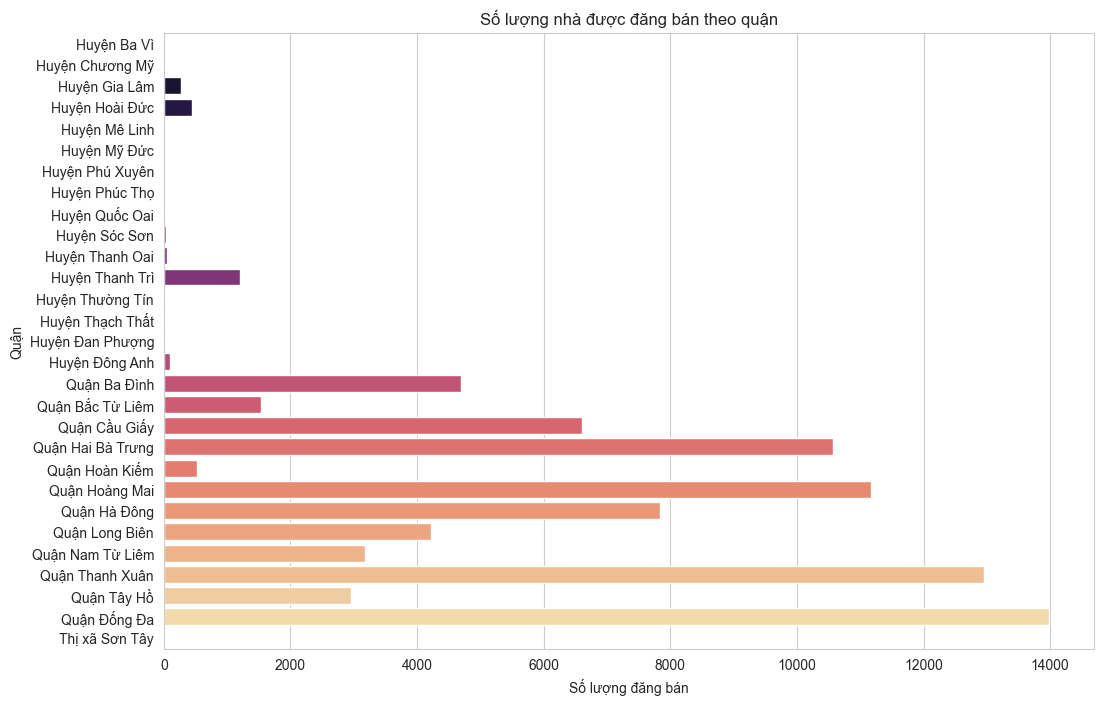

In [246]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
sns.countplot(data=df, y='Quận', palette='magma')
plt.title('Số lượng nhà được đăng bán theo quận')
plt.xlabel('Số lượng đăng bán')
plt.ylabel('Quận')
plt.show()

### Cột 'Giấy tờ pháp lý'

***Ordinal Category***

Việc chuyển sang Ordinal Category cũng giống như Norminal Category, nhưng ta sẽ thêm vào đó order của các giá trị.<br>
Ví dụ, 'thấp' < 'trung bình' < 'cao'

In [57]:
df['Giấy tờ pháp lý'].unique()

array(['Đã có sổ', 'Unknown', 'Đang chờ sổ', 'Giấy tờ khác'], dtype=object)

Ở đây ta có 'Đã có sổ', nan, 'Đang chờ sổ', 'Giấy tờ khác', vậy ta có thể giả định ra thứ tự của nó.<br>

'Unknown < 'Giấy tờ khác' < 'Đang chờ sổ' < 'Đã có sổ'

In [58]:
# Trước khi chuyển sang ordinal category

df[df['Giấy tờ pháp lý'] > 'Giấy tờ khác']['Giấy tờ pháp lý'].unique()

array(['Đã có sổ', 'Unknown', 'Đang chờ sổ'], dtype=object)

In [59]:
# Sau khi chuyển sang ordinal category

giay_to_phap_ly = ['Unknown', 'Giấy tờ khác', 'Đang chờ sổ', 'Đã có sổ']
df['Giấy tờ pháp lý'] = df['Giấy tờ pháp lý'].astype(CategoricalDtype(categories=giay_to_phap_ly, ordered=True))

In [60]:
df[df['Giấy tờ pháp lý'] > 'Giấy tờ khác']['Giấy tờ pháp lý'].unique()

['Đã có sổ', 'Đang chờ sổ']
Categories (4, object): ['Unknown' < 'Giấy tờ khác' < 'Đang chờ sổ' < 'Đã có sổ']

*Note*: Có thể thấy, khi lọc các entries ở cột "Giấy tờ pháp lý" có giá trị cao hơn "Giấy tờ khác", sẽ trả về các entries có giá trị là "Đã có sổ" và "Đang chờ sổ" đúng như order ta mong muốn.

In [61]:
df['Giấy tờ pháp lý'].head()

0    Đã có sổ
1     Unknown
2    Đã có sổ
3    Đã có sổ
4     Unknown
Name: Giấy tờ pháp lý, dtype: category
Categories (4, object): ['Unknown' < 'Giấy tờ khác' < 'Đang chờ sổ' < 'Đã có sổ']

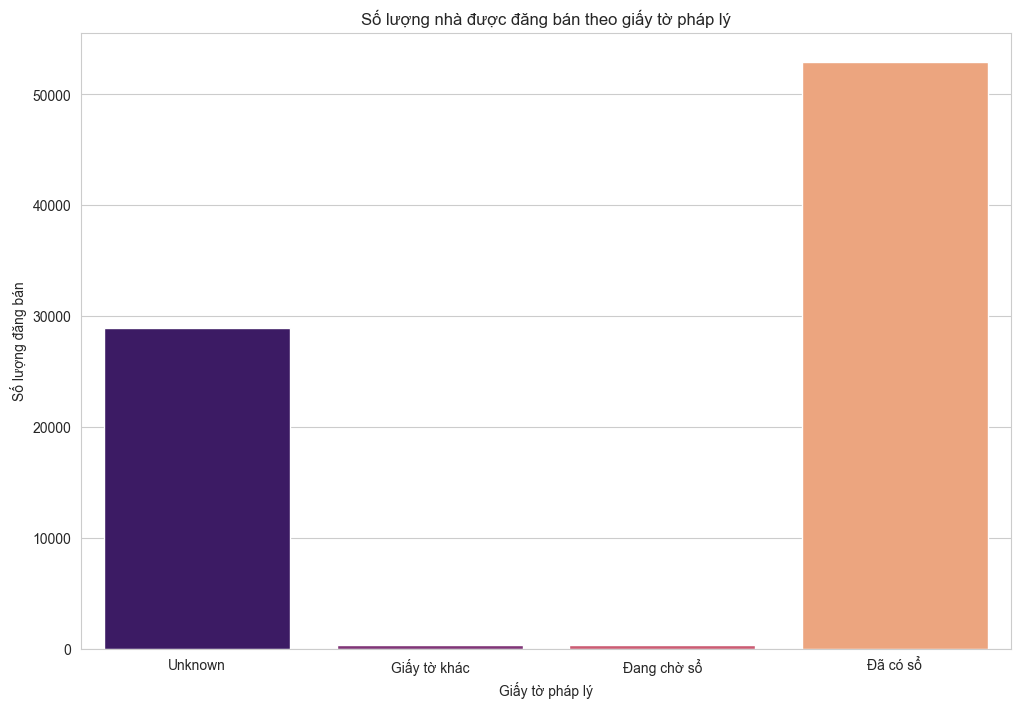

In [244]:
plt.figure(figsize=(12, 8))
sns.countplot(data=df, x='Giấy tờ pháp lý', palette='magma')
plt.title('Số lượng nhà được đăng bán theo giấy tờ pháp lý')
plt.xlabel('Giấy tờ pháp lý')
plt.ylabel('Số lượng đăng bán')
plt.show()

### Cột 'Loại hình nhà ở'

In [63]:
df['Loại hình nhà ở'].unique()

array(['Nhà ngõ, hẻm', 'Nhà mặt phố, mặt tiền', 'Nhà biệt thự',
       'Nhà phố liền kề'], dtype=object)

In [64]:
loai_hinh_nha_o = ['Nhà ngõ, hẻm', 'Nhà mặt phố, mặt tiền', 'Nhà phố liền kề', 'Nhà biệt thự']
df['Loại hình nhà ở'] = df['Loại hình nhà ở'].astype(CategoricalDtype(categories=loai_hinh_nha_o, ordered=True))

In [65]:
df['Loại hình nhà ở'].head()

0             Nhà ngõ, hẻm
1    Nhà mặt phố, mặt tiền
2             Nhà ngõ, hẻm
3             Nhà ngõ, hẻm
4             Nhà ngõ, hẻm
Name: Loại hình nhà ở, dtype: category
Categories (4, object): ['Nhà ngõ, hẻm' < 'Nhà mặt phố, mặt tiền' < 'Nhà phố liền kề' < 'Nhà biệt thự']

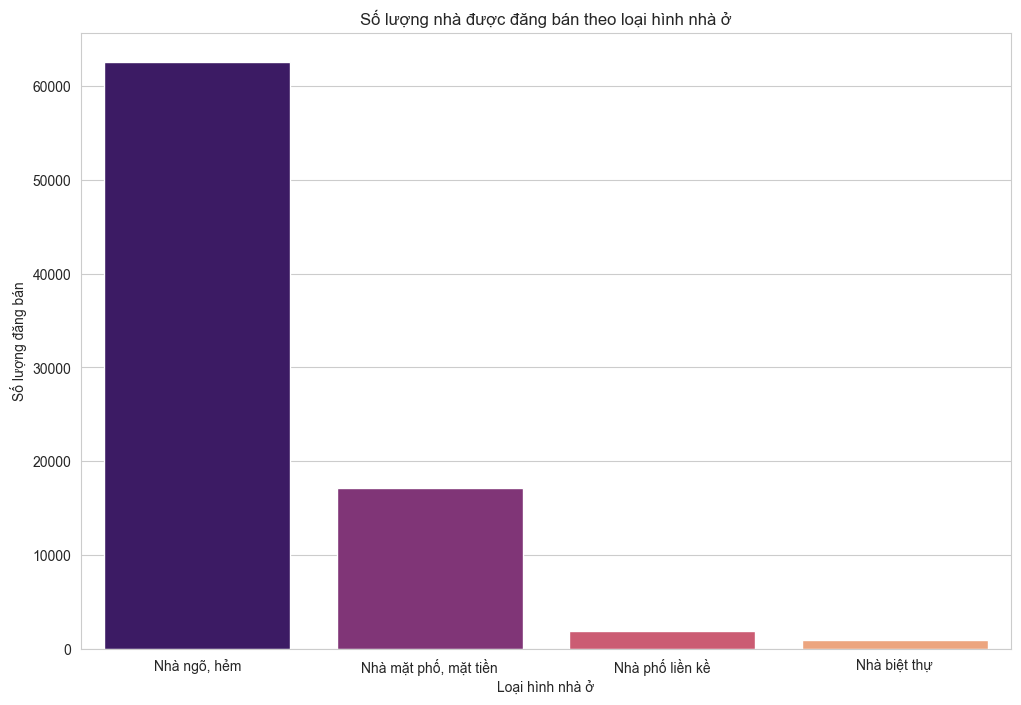

In [243]:
plt.figure(figsize=(12, 8))
sns.countplot(data=df, x='Loại hình nhà ở', palette='magma')
plt.title('Số lượng nhà được đăng bán theo loại hình nhà ở')
plt.xlabel('Loại hình nhà ở')
plt.ylabel('Số lượng đăng bán')
plt.show()

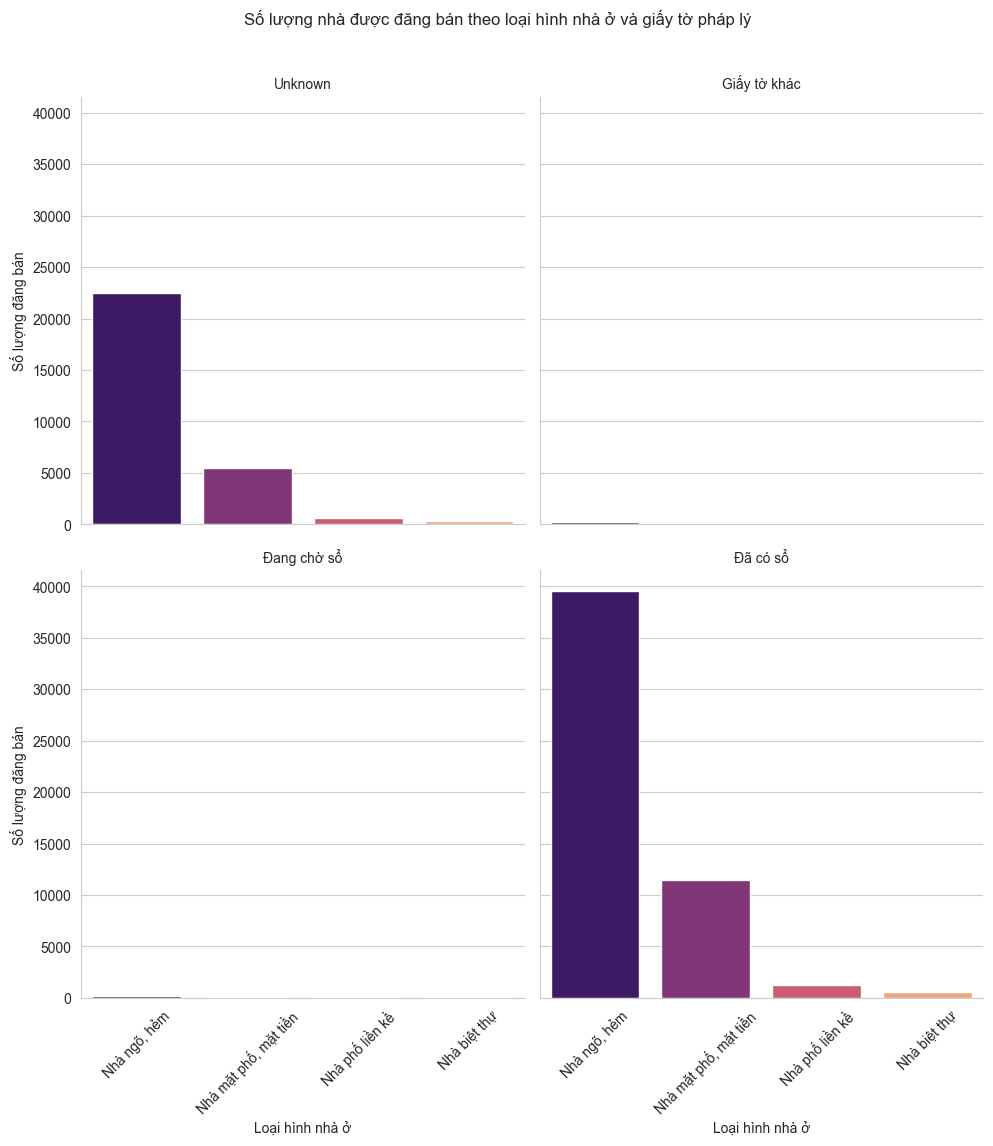

In [242]:
g = sns.catplot(data=df, x='Loại hình nhà ở', col='Giấy tờ pháp lý', kind='count', col_wrap=2, palette='magma')
g.set_axis_labels('Loại hình nhà ở', 'Số lượng đăng bán')
g.fig.suptitle('Số lượng nhà được đăng bán theo loại hình nhà ở và giấy tờ pháp lý', y=1.05)
g.set_titles('{col_name}')
g.tick_params(axis='x', rotation=45)

plt.show()

### Cột phường

In [68]:
df['Phường'].unique()

array(['Phường Nghĩa Đô', 'Phường Kim Giang', 'Phường Minh Khai',
       'Phường Thụy Khuê', 'Phường Yên Hoà', 'Phường Trung Liệt',
       'Phường Đống Mác', 'Phường Xuân La', 'Phường Văn Quán',
       'Thị trấn Văn Điển', 'Phường Định Công', 'Phường Bồ Đề',
       'Phường Quang Trung', 'Phường Thanh Lương', 'Phường Khương Trung',
       'Phường Phúc Tân', 'Phường Gia Thụy', 'Phường Khương Đình',
       'Phường Phương Canh', 'Phường Tương Mai', 'Phường La Khê',
       'Phường Mễ Trì', 'Phường Khương Mai', 'Phường Láng Hạ',
       'Phường Quan Hoa', 'Phường Tây Mỗ', 'Phường Ngọc Khánh',
       'Phường Đại Mỗ', 'Xã Tả Thanh Oai', 'Phường Mỹ Đình 1',
       'Xã Tam Hiệp', 'Phường Cống Vị', 'Phường Bách Khoa',
       'Phường Vĩnh Phúc', 'Xã Kim Chung', 'Phường Đại Kim',
       'Phường Mai Động', 'Phường Trung Tự', 'Phường Kiến Hưng',
       'Phường Trúc Bạch', 'Phường Cổ Nhuế 1', 'Phường Đức Giang',
       'Phường Mỹ Đình 2', 'Phường Bưởi', 'Phường Ô Chợ Dừa',
       'Phường Long Biên', 'P

In [69]:
df['Phường'] = df['Phường'].astype('category')

### Cột 'Số tầng'

In [70]:
df['Số tầng'].unique()

array(['4', 'Unknown', '6', '5', '7', '2', '3', '8', '1', '9', '50', '38',
       '35', '10', 'Nhiều hơn 10', '45', '33', '42', '25', '73', '12',
       '65', '55', '30', '14', '40', '52', '54', '32', '29'], dtype=object)

In [71]:
df['Số tầng'].value_counts()

Số tầng
Unknown         46089
5               15767
4               12277
3                3619
6                2119
2                1028
1                 636
7                 597
8                 188
9                  88
10                 36
45                  8
Nhiều hơn 10        7
35                  6
50                  2
12                  2
38                  2
30                  1
32                  1
54                  1
52                  1
40                  1
14                  1
65                  1
55                  1
73                  1
25                  1
42                  1
33                  1
29                  1
Name: count, dtype: int64

Số lượng các nhà có tầng nhiều hơn 10 nhỏ, do vậy ta đưa chúng về '>10'

In [72]:
def process_so_tang(x):
    try:
        if x == 'Nhiều hơn 10' or int(x) > 10:
            return '>10'
        return x
    except:
        return x

In [73]:
df['Số tầng'] = df['Số tầng'].apply(process_so_tang)

In [74]:
df['Số tầng'].value_counts()

Số tầng
Unknown    46089
5          15767
4          12277
3           3619
6           2119
2           1028
1            636
7            597
8            188
9             88
>10           40
10            36
Name: count, dtype: int64

In [75]:
# Đưa cột 'Số tầng' về kiểu ordinal category

so_tang = ['Unknown', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '>10']
df['Số tầng'] = df['Số tầng'].astype(CategoricalDtype(categories=so_tang, ordered=True))

In [76]:
df['Số tầng'].head()

0          4
1    Unknown
2          4
3    Unknown
4    Unknown
Name: Số tầng, dtype: category
Categories (12, object): ['Unknown' < '1' < '2' < '3' ... '8' < '9' < '10' < '>10']

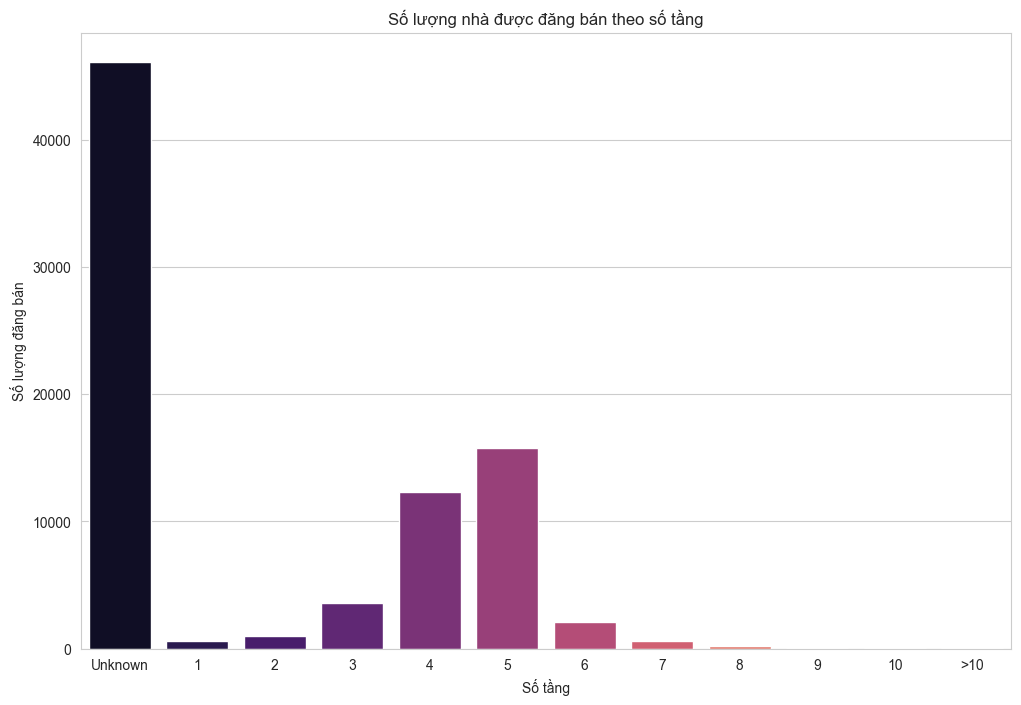

In [241]:
plt.figure(figsize=(12, 8))
sns.countplot(data=df, x='Số tầng', palette='magma')
plt.title('Số lượng nhà được đăng bán theo số tầng')
plt.xlabel('Số tầng')
plt.ylabel('Số lượng đăng bán')
plt.show()

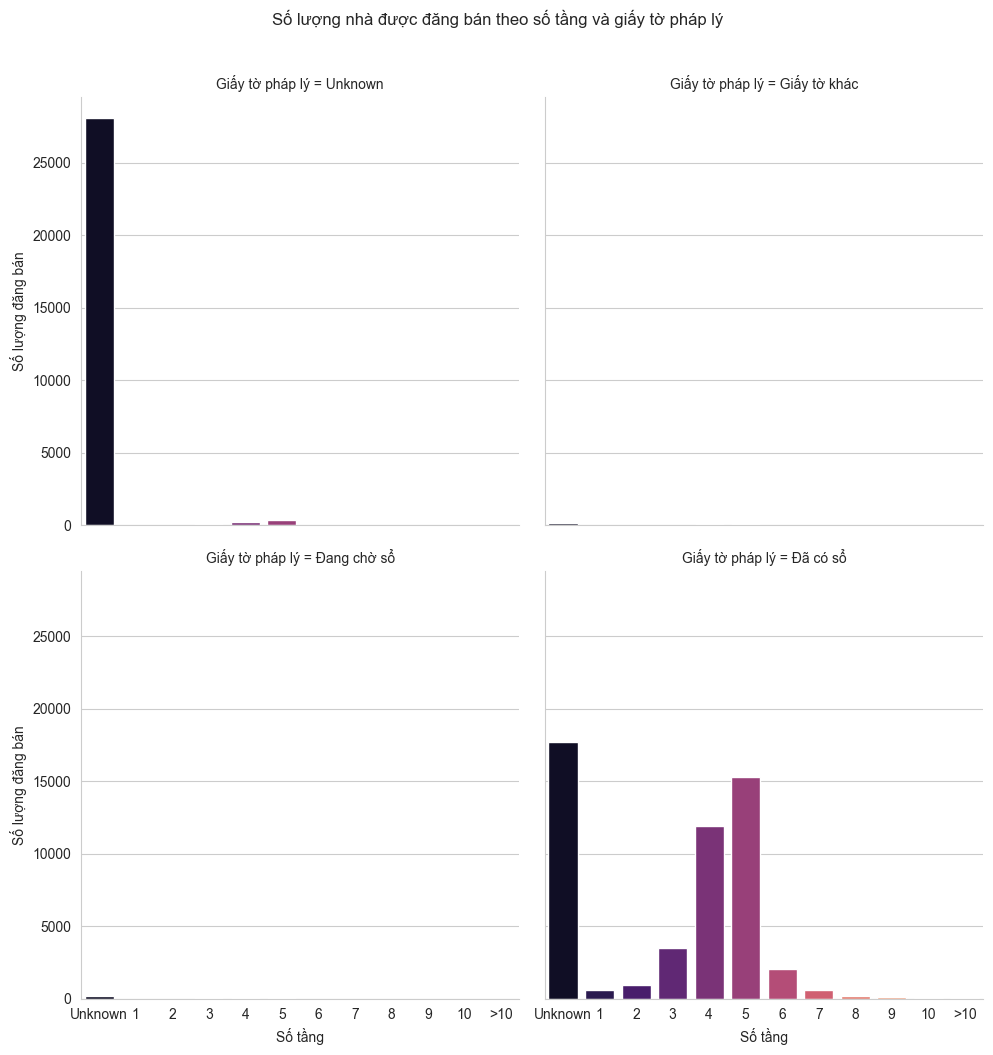

In [240]:
g = sns.catplot(data=df, x='Số tầng', col='Giấy tờ pháp lý', kind='count', col_wrap=2, palette='magma')
g.fig.suptitle('Số lượng nhà được đăng bán theo số tầng và giấy tờ pháp lý', y=1.05)
g.set_axis_labels('Số tầng', 'Số lượng đăng bán')
plt.show()

### Cột 'Số phòng ngủ'

In [79]:
df['Số phòng ngủ'].unique()

array(['5 phòng', '3 phòng', '4 phòng', '6 phòng', 'nhiều hơn 10 phòng',
       '8 phòng', '2 phòng', '7 phòng', '9 phòng', '1 phòng', '10 phòng'],
      dtype=object)

In [80]:
# Đưa category 'nhiều hơn 10 phòng' về 15 phòng

df['Số phòng ngủ'].replace('nhiều hơn 10 phòng', '15 phòng', inplace=True)

In [81]:
# Đưa cột 'Số phòng ngủ' về kiểu numeric

df['Số phòng ngủ'] = df['Số phòng ngủ'].str.replace('phòng', '')
df['Số phòng ngủ'] = df['Số phòng ngủ'].astype('int')

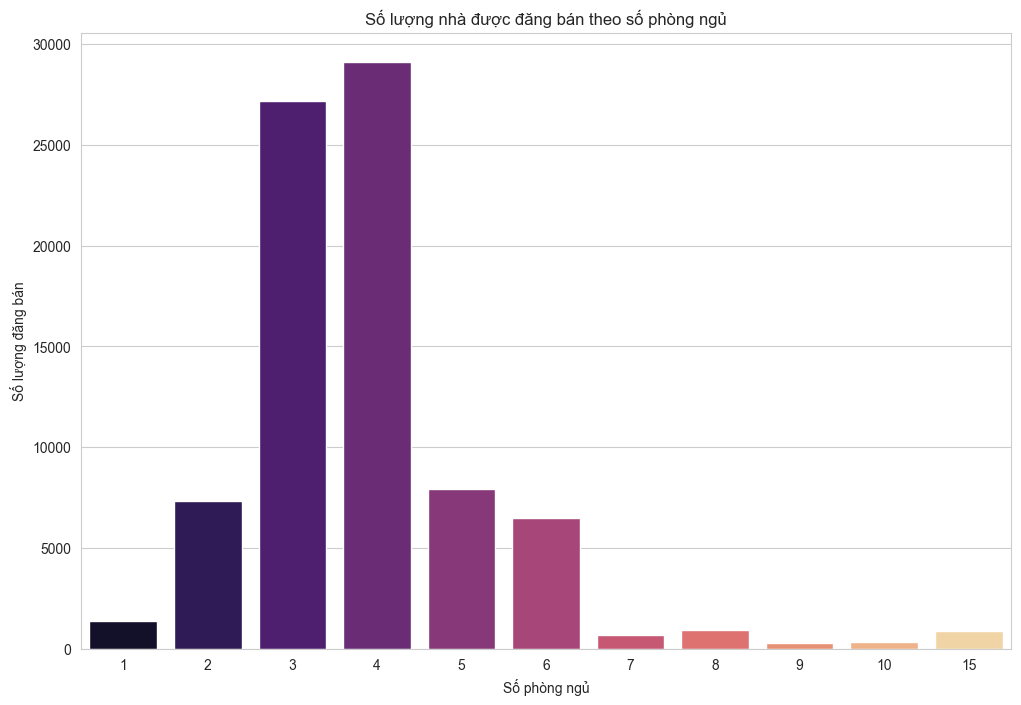

In [239]:
plt.figure(figsize=(12, 8))
sns.countplot(data=df, x='Số phòng ngủ', palette='magma')
plt.title('Số lượng nhà được đăng bán theo số phòng ngủ')
plt.xlabel('Số phòng ngủ')
plt.ylabel('Số lượng đăng bán')
plt.show()

### Cột 'Diện tích'

In [83]:
df['Diện tích'] = df['Diện tích'].apply(lambda x: x.replace('m²', '').replace(',', '.')).astype(float)

### Cột 'Giá/m2'

In [84]:
df['Giá/m2'].value_counts()

Giá/m2
100 triệu/m²       2503
80 triệu/m²        1156
75 triệu/m²         963
90 triệu/m²         839
83,33 triệu/m²      810
                   ... 
126,25 triệu/m²       1
107,43 triệu/m²       1
67.567 đ/m²           1
116,49 triệu/m²       1
341,46 triệu/m²       1
Name: count, Length: 8345, dtype: int64

In [85]:
print('Đơn vị tính:')
don_vi_tinh = df['Giá/m2'].apply(lambda x: x.split(' ')[1])
don_vi_tinh.value_counts()

Đơn vị tính:


Giá/m2
triệu/m²    81626
đ/m²          740
tỷ/m²         118
Name: count, dtype: int64

In [86]:
df[don_vi_tinh == 'đ/m²']

Ngày              Quận                Phường  \
93    2020-08-04  Quận Nam Từ Liêm       Phường Cầu Diễn   
174   2020-08-04  Quận Nam Từ Liêm      Phường Mỹ Đình 1   
283   2020-08-04      Quận Đống Đa       Phường Kim Liên   
338   2020-08-04    Quận Long Biên      Phường Ngọc Thụy   
351   2020-08-04    Quận Hoàng Mai        Phường Tân Mai   
...          ...               ...                   ...   
82282 2020-05-10       Quận Tây Hồ        Phường Xuân La   
82304 2020-05-07      Quận Đống Đa    Phường Láng Thượng   
82313 2020-05-04      Quận Đống Đa      Phường Ô Chợ Dừa   
82332 2020-04-27    Quận Hoàng Mai  Phường Hoàng Văn Thụ   
82337 2020-04-22      Quận Đống Đa       Phường Thổ Quan   

             Loại hình nhà ở Giấy tờ pháp lý  Số tầng  Số phòng ngủ  \
93           Nhà phố liền kề        Đã có sổ        5             4   
174             Nhà ngõ, hẻm         Unknown  Unknown             1   
283             Nhà ngõ, hẻm         Unknown  Unknown             3   
338             Nhà ngõ, hẻm        Đã có sổ  Unknown             3   
351    Nhà mặt phố, mặt tiền        Đã có sổ        5             6   
...                      ...             ...      ...           ...   
82282           Nhà ngõ, hẻm        Đã có sổ        6             5   
82304           Nhà ngõ, hẻm        Đã có sổ  Unknown             4   
82313           Nhà ngõ, hẻm        Đã có sổ  Unknown             4   
82332           Nhà ngõ, hẻm         Unknown  Unknown             3   
82337           Nhà ngõ, hẻm        Đã có sổ  Unknown             3   

          Diện tích        Giá/m2  
93    113.000000000  247.787 đ/m²  
174    30.000000000        1 đ/m²  
283    42.000000000   90.476 đ/m²  
338   140.000000000  178.571 đ/m²  
351    60.000000000  125.000 đ/m²  
...             ...           ...  
82282  49.000000000   59.183 đ/m²  
82304  45.000000000   85.555 đ/m²  
82313  38.000000000   86.842 đ/m²  
82332  46.000000000   69.565 đ/m²  
82337  35.000000000  105.714 đ/m²  

[740 rows x 9 columns]

**Nhận xét**: Có thể đ/m² chính là triệu/m²

In [87]:
df[don_vi_tinh == 'tỷ/m²']

Ngày               Quận                   Phường  \
1100  2020-08-04    Quận Thanh Xuân      Phường Khương Trung   
1144  2020-08-04       Quận Đống Đa           Phường Láng Hạ   
1657  2020-08-04       Quận Hà Đông            Phường La Khê   
2849  2020-08-03    Quận Thanh Xuân  Phường Thanh Xuân Trung   
2939  2020-08-03  Quận Hai Bà Trưng         Phường Minh Khai   
...          ...                ...                      ...   
78096 2020-06-09     Huyện Hoài Đức              Xã Vân Canh   
79023 2020-06-09       Quận Đống Đa       Phường Láng Thượng   
79824 2020-06-08       Quận Đống Đa          Phường Nam Đồng   
80211 2020-06-08     Quận Hoàn Kiếm        Phường Lý Thái Tổ   
81834 2020-06-06       Quận Đống Đa       Phường Láng Thượng   

             Loại hình nhà ở Giấy tờ pháp lý  Số tầng  Số phòng ngủ  \
1100            Nhà ngõ, hẻm         Unknown  Unknown             3   
1144            Nhà ngõ, hẻm        Đã có sổ        5             3   
1657         Nhà phố liền kề         Unknown  Unknown             6   
2849            Nhà ngõ, hẻm         Unknown  Unknown             2   
2939            Nhà ngõ, hẻm        Đã có sổ  Unknown             5   
...                      ...             ...      ...           ...   
78096           Nhà ngõ, hẻm        Đã có sổ        4             3   
79023           Nhà ngõ, hẻm        Đã có sổ        4             4   
79824           Nhà ngõ, hẻm        Đã có sổ  Unknown             3   
80211  Nhà mặt phố, mặt tiền         Unknown  Unknown             4   
81834        Nhà phố liền kề        Đã có sổ        7            15   

          Diện tích             Giá/m2  
1100   36.000000000  1,202777777 tỷ/m²  
1144   35.000000000  1,142857142 tỷ/m²  
1657    5.000000000         1,96 tỷ/m²  
2849   35.000000000  1,557142857 tỷ/m²  
2939    3.990000000  1,316666666 tỷ/m²  
...             ...                ...  
78096  30.000000000  5,833333333 tỷ/m²  
79023  40.000000000       1,0125 tỷ/m²  
79824  45.000000000  1,706666666 tỷ/m²  
80211 100.000000000          1,5 tỷ/m²  
81834  65.000000000  2,538461538 tỷ/m²  

[118 rows x 9 columns]

Ta sẽ xử lý bằng cách thêm cột "Đơn vị tính", và bỏ đơn vị trong cột "Giá/m2", đưa các giá trị trong cột "Giá/m2" về numerical

In [88]:
df['Đơn vị tính'] = df['Giá/m2'].apply(lambda x: x.split(' ')[1])
df['Giá/m2'] = df['Giá/m2'].apply(lambda x: x.split(' ')[0])

In [89]:
df['Đơn vị tính'] = df['Đơn vị tính'].astype('category')

Trong cột 'Giá/m2' có các giá trị không thể chuyển sang float

In [90]:
idx, values = extract_idx_value(df['Giá/m2'].apply(lambda x: x.replace(',', '.')))

for _idx, value in zip(idx, values):
    try:
        float(value)
    except:
        print(_idx, value)

52315 2.222.22220022
55649 728.000.00728
57999 69.736.842105263


**Nhận xét**: Các giá trị cũng không hợp lý với cột 'Giá/m2'

In [91]:
df.drop([52315, 55649, 57999], inplace=True)
df['Giá/m2'] = df['Giá/m2'].apply(lambda x: x.replace(',', '.')).astype(float)

In [92]:
df.reset_index(drop=True, inplace=True)

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82481 entries, 0 to 82480
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Ngày             82481 non-null  datetime64[ns]
 1   Quận             82481 non-null  category      
 2   Phường           82481 non-null  category      
 3   Loại hình nhà ở  82481 non-null  category      
 4   Giấy tờ pháp lý  82481 non-null  category      
 5   Số tầng          82481 non-null  category      
 6   Số phòng ngủ     82481 non-null  int32         
 7   Diện tích        82481 non-null  float64       
 8   Giá/m2           82481 non-null  float64       
 9   Đơn vị tính      82481 non-null  category      
dtypes: category(6), datetime64[ns](1), float64(2), int32(1)
memory usage: 2.8 MB


**Nhận xét**: Dữ liệu đã được làm sạch về kiểu dữ liệu

In [94]:
df.describe()

Ngày    Số phòng ngủ        Diện tích  \
count                          82481 82481.000000000  82481.000000000   
mean   2020-07-07 16:47:42.506516736     3.924188601     51.365493993   
min              2019-08-05 00:00:00     1.000000000      1.000000000   
25%              2020-06-23 00:00:00     3.000000000     34.000000000   
50%              2020-07-09 00:00:00     4.000000000     40.000000000   
75%              2020-07-24 00:00:00     4.000000000     50.000000000   
max              2020-08-05 00:00:00    15.000000000 111411.000000000   
std                              NaN     1.734691080    470.715103207   

               Giá/m2  
count 82481.000000000  
mean    102.919835309  
min       1.000000000  
25%      73.200000000  
50%      90.000000000  
75%     110.750000000  
max     998.000000000  
std      66.060850235

# Feature Engineering

Tạo feature 'Giá' bằng 'Giá/m2' * 'Diện tích' với đơn vị là tỷ.
Các entries có 'Đơn vị tính' là 'triệu/m²' sẽ chia cho 1000

In [95]:
for row, col in df.iterrows():
    df.loc[row, 'Giá'] = col['Giá/m2'] * col['Diện tích']
    if col['Đơn vị tính'] != 'tỷ/m²':
        df.loc[row, 'Giá'] /= 1000

Tạo feature 'Nội thành'

In [96]:
df['Nội thành'] = df['Quận'].apply(lambda x: 1 if 'Quận' in x else 0)

Tạo feature 'Năm', 'Tháng'

In [97]:
df['Năm'] = df['Ngày'].dt.year
df['Tháng'] = df['Ngày'].dt.month

### **Note**: Trước khi phân tích sâu hơn về dữ liệu, cần chia train-set, test-test

In [98]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

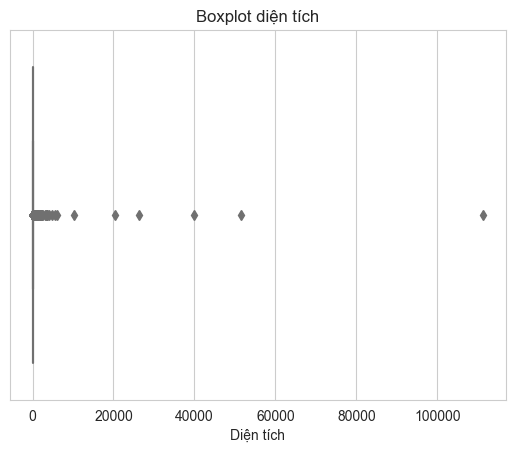

In [237]:
sns.boxplot(data=df_train, x='Diện tích', color='#F38181')
plt.title('Boxplot diện tích')
plt.xlabel('Diện tích')
plt.show()

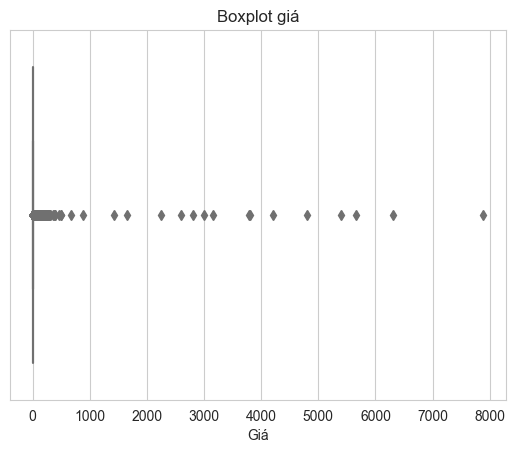

In [238]:
sns.boxplot(data=df_train, x='Giá', color='#F38181')
plt.title('Boxplot giá')
plt.xlabel('Giá')
plt.show()

**Nhận xét**: Với dữ liệu có giá trị outliers quá lớn như này, ta cần loại bỏ để có thể phân tích dễ dàng hơn, và xây dựng được mô hình dự đoán tốt hơn

In [101]:
# iqr_dien_tich = df_train['Diện tích'].quantile(0.75) - df_train['Diện tích'].quantile(0.25)
# upper_bound_dien_tich  = df_train['Diện tích'].quantile(0.75) + 1.5 * iqr_dien_tich
# lower_bound_dien_tich = df_train['Diện tích'].quantile(0.25) - 1.5 * iqr_dien_tich

# df_train_no_outlier_dien_tich = df_train[(df_train['Diện tích'] < upper_bound_dien_tich) & (df_train['Diện tích'] > lower_bound_dien_tich)]

In [102]:
# print(f'Số lượng outlier: {len(df_train) - len(df_train_no_outlier_dien_tich)}')

In [103]:
# iqr_gia = df_train_no_outlier_dien_tich['Giá'].quantile(0.75) - df_train_no_outlier_dien_tich['Giá'].quantile(0.25)
# upper_bound_gia = df_train_no_outlier_dien_tich['Giá'].quantile(0.75) + 1.5 * iqr_gia
# lower_bound_gia = df_train_no_outlier_dien_tich['Giá'].quantile(0.25) - 1.5 * iqr_gia

# df_train_no_outlier = df_train_no_outlier_dien_tich[(df_train_no_outlier_dien_tich['Giá'] < upper_bound_gia) & (df_train_no_outlier_dien_tich['Giá'] > lower_bound_gia)]

In [104]:
iqr = df_train['Giá'].quantile(0.75) - df_train['Giá'].quantile(0.25)
upper_bound = df_train['Giá'].quantile(0.75) + 1.5 * iqr
lower_bound = df_train['Giá'].quantile(0.25) - 1.5 * iqr

df_train_no_outlier = df_train[(df_train['Giá'] < upper_bound) & (df_train['Giá'] > lower_bound)]

In [105]:
print(f'Số lượng outlier: {len(df_train) - len(df_train_no_outlier)}')

Số lượng outlier: 5998


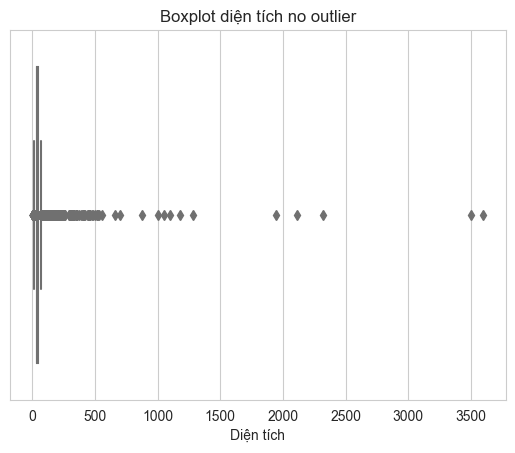

In [236]:
sns.boxplot(data=df_train_no_outlier, x='Diện tích', color='#F38181')
plt.title('Boxplot diện tích no outlier')
plt.xlabel('Diện tích')
plt.show()

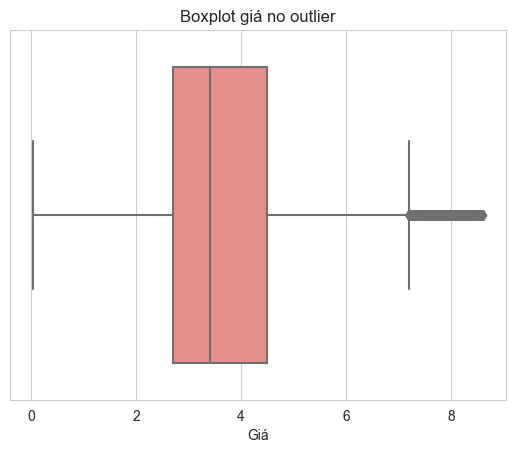

In [234]:
sns.boxplot(data=df_train_no_outlier, x='Giá', color='#F38181')
plt.title('Boxplot giá no outlier')
plt.xlabel('Giá')
plt.show()

In [108]:
df_train_no_outlier.describe()

Ngày    Số phòng ngủ       Diện tích  \
count                          59986 59986.000000000 59986.000000000   
mean   2020-07-07 20:32:36.936618496     3.766562198    43.010886207   
min              2019-08-05 00:00:00     1.000000000     1.000000000   
25%              2020-06-23 00:00:00     3.000000000    33.000000000   
50%              2020-07-09 00:00:00     4.000000000    40.000000000   
75%              2020-07-24 00:00:00     4.000000000    48.000000000   
max              2020-08-05 00:00:00    15.000000000  3600.000000000   
std                              NaN     1.439798978    33.060746220   

               Giá/m2             Giá       Nội thành             Năm  \
count 59986.000000000 59986.000000000 59986.000000000 59986.000000000   
mean     90.638735977     3.738515133     0.972293535  2019.999799953   
min       1.000000000     0.026000000     0.000000000  2019.000000000   
25%      71.670000000     2.699900000     1.000000000  2020.000000000   
50%      87.180000000     3.400000000     1.000000000  2020.000000000   
75%     103.850000000     4.500000000     1.000000000  2020.000000000   
max     990.000000000     8.620080000     1.000000000  2020.000000000   
std      35.051544716     1.561772149     0.164131855     0.014142489   

                Tháng  
count 59986.000000000  
mean      6.724635748  
min       2.000000000  
25%       6.000000000  
50%       7.000000000  
75%       7.000000000  
max      12.000000000  
std       0.638457095

In [109]:
print('Giá nhà cao nhất:', df_train_no_outlier['Giá'].max(), 'tỷ')
print('Giá nhà thấp nhất:', df_train_no_outlier['Giá'].min(), 'tỷ')

Giá nhà cao nhất: 8.62008 tỷ
Giá nhà thấp nhất: 0.026 tỷ


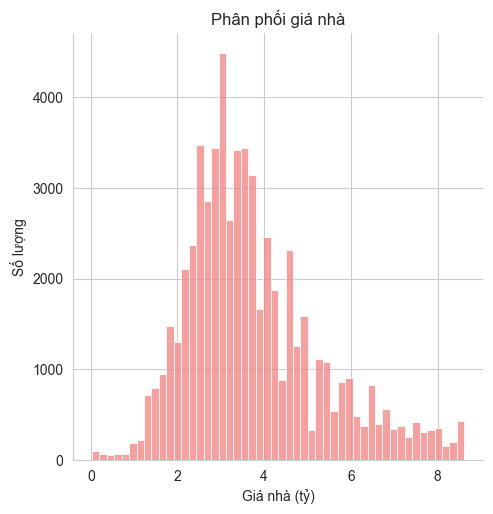

In [233]:
sns.displot(data=df_train_no_outlier, x='Giá', bins=50, kde=False, color='#F38181')
plt.title('Phân phối giá nhà')
plt.xlabel('Giá nhà (tỷ)')
plt.ylabel('Số lượng')
plt.show()

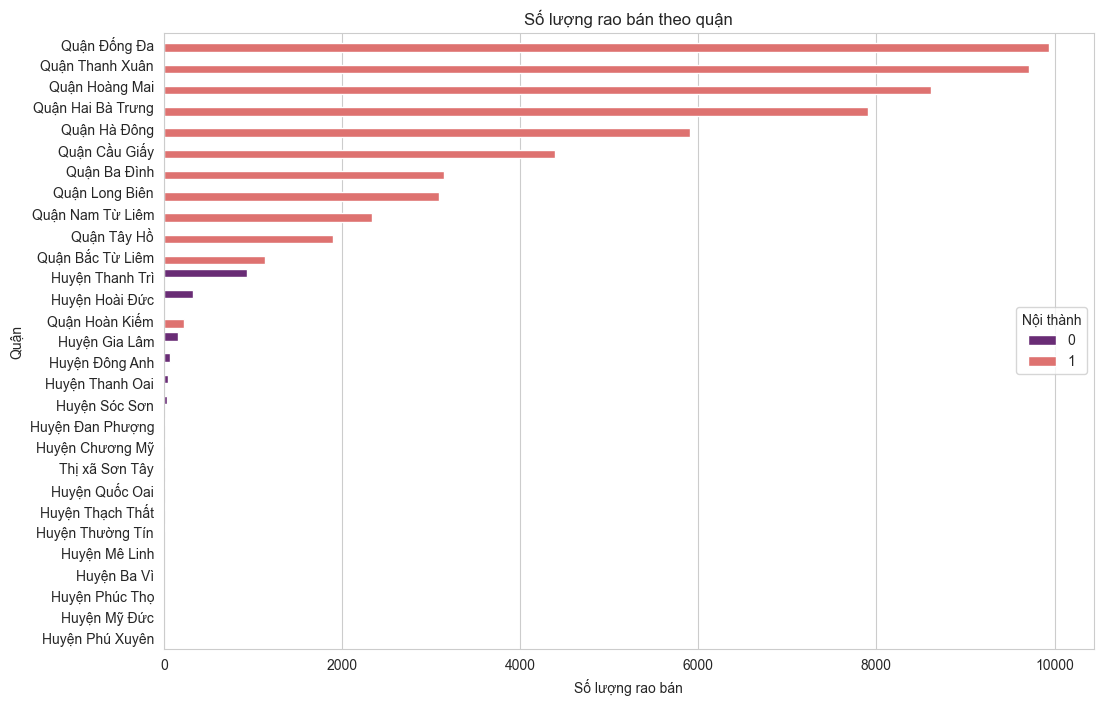

In [111]:
plt.figure(figsize=(12, 8))
sns.countplot(data=df_train_no_outlier, y='Quận', hue='Nội thành', order=df_train_no_outlier['Quận'].value_counts().index, palette='magma')
plt.title('Số lượng rao bán theo quận')
plt.xlabel('Số lượng rao bán')
plt.ylabel('Quận')
plt.show()

In [112]:
df_train_no_outlier.groupby('Quận')['Giá'].mean().sort_values(ascending=False)

Quận
Huyện Thạch Thất    4.716751818
Quận Cầu Giấy       4.614868398
Huyện Ba Vì         4.550900000
Quận Tây Hồ         4.331509429
Quận Ba Đình        4.035464759
Quận Đống Đa        3.962753463
Quận Hoàn Kiếm      3.938248184
Quận Thanh Xuân     3.903992474
Huyện Đan Phượng    3.873916667
Huyện Quốc Oai      3.823306923
Quận Nam Từ Liêm    3.738562248
Quận Long Biên      3.669182394
Quận Hai Bà Trưng   3.647365911
Quận Bắc Từ Liêm    3.561365469
Huyện Gia Lâm       3.354397628
Quận Hà Đông        3.271504117
Quận Hoàng Mai      3.270854406
Huyện Mê Linh       3.138794286
Huyện Mỹ Đức        2.899700000
Huyện Chương Mỹ     2.689513750
Huyện Thanh Trì     2.679601371
Huyện Đông Anh      2.545112824
Thị xã Sơn Tây      2.434942857
Huyện Phúc Thọ      2.312555000
Huyện Sóc Sơn       2.241320000
Huyện Thường Tín    2.163403636
Huyện Hoài Đức      2.046004912
Huyện Thanh Oai     1.633831978
Huyện Phú Xuyên             NaN
Name: Giá, dtype: float64

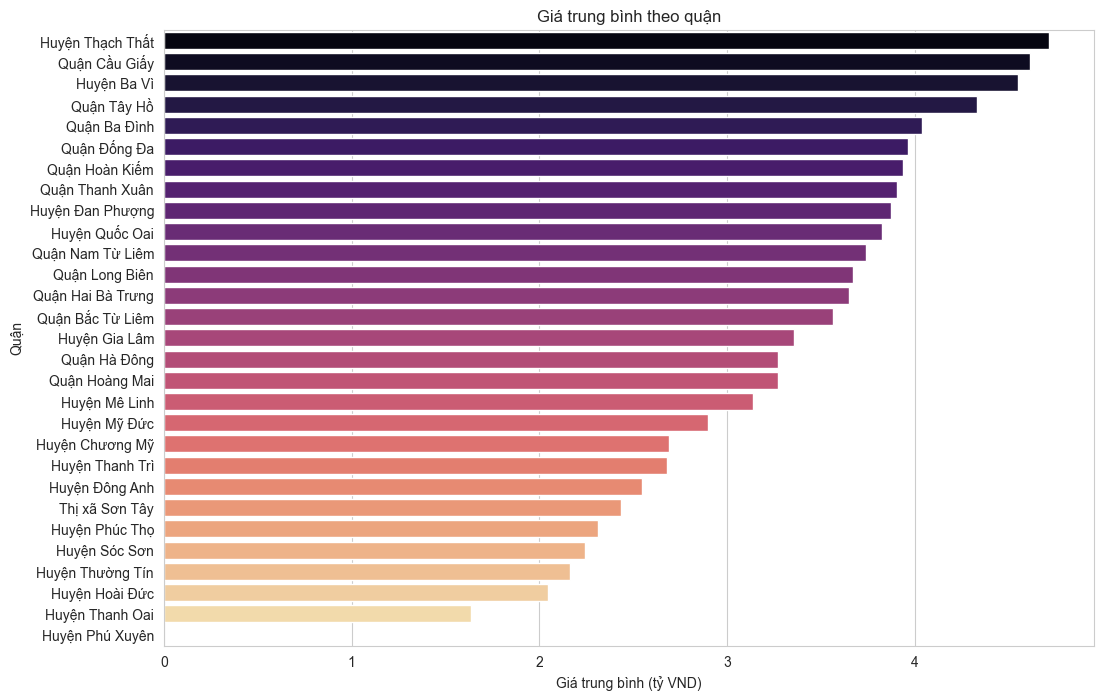

In [229]:
gia_trung_binh_theo_quan = df_train_no_outlier.groupby('Quận')['Giá'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(
    x=gia_trung_binh_theo_quan.values, y=gia_trung_binh_theo_quan.index,
    order=gia_trung_binh_theo_quan.index, palette='magma'
)
plt.xlabel('Giá trung bình (tỷ VND)')
plt.ylabel('Quận')
plt.title('Giá trung bình theo quận')
plt.show()

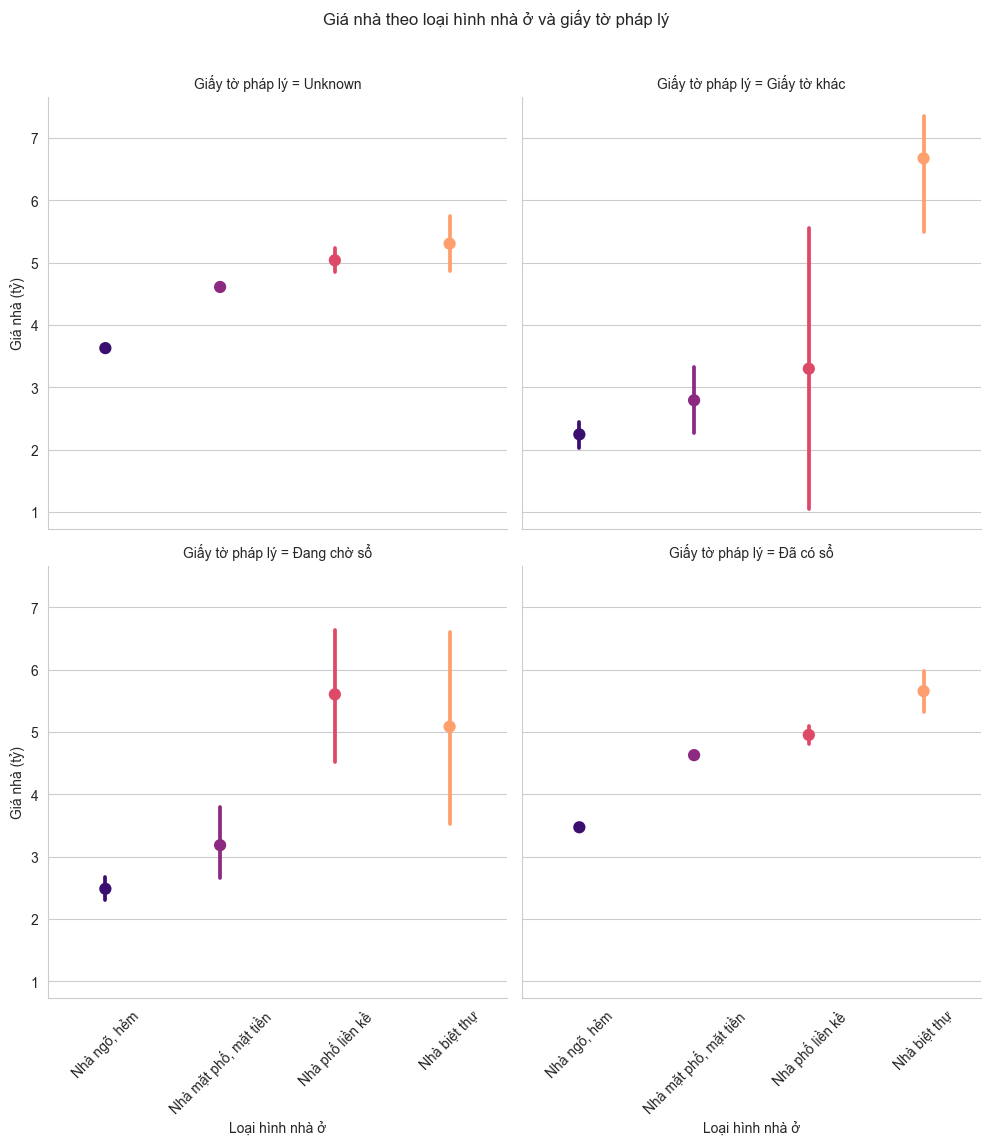

In [227]:
g = sns.catplot(data=df_train_no_outlier, x='Loại hình nhà ở', y='Giá', palette='magma', col='Giấy tờ pháp lý', col_wrap=2, kind='point')
g.set_axis_labels('Loại hình nhà ở', 'Giá nhà (tỷ)')
g.fig.suptitle('Giá nhà theo loại hình nhà ở và giấy tờ pháp lý', y=1.05)
g.tick_params(axis='x', rotation=45)
plt.show()

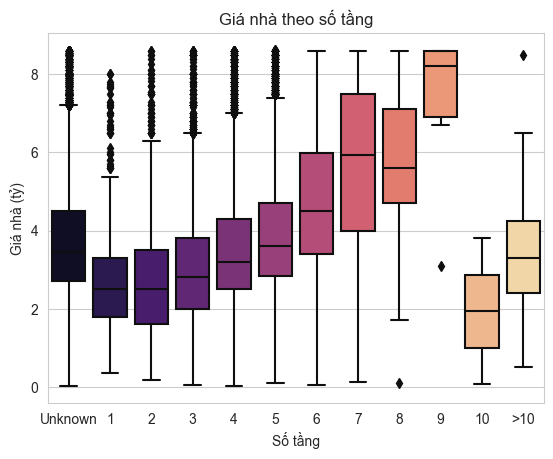

In [226]:
sns.boxplot(data=df_train_no_outlier, x='Số tầng', y='Giá', palette='magma')
plt.title('Giá nhà theo số tầng')
plt.xlabel('Số tầng')
plt.ylabel('Giá nhà (tỷ)')
plt.show()

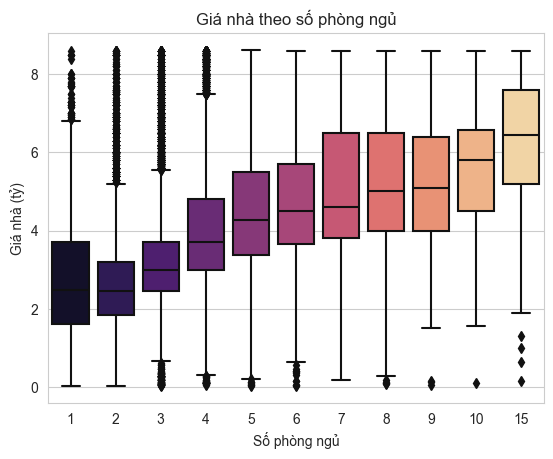

In [116]:
sns.boxplot(data=df_train_no_outlier, x='Số phòng ngủ', y='Giá', palette='magma')
plt.title('Giá nhà theo số phòng ngủ')
plt.xlabel('Số phòng ngủ')
plt.ylabel('Giá nhà (tỷ)')
plt.show()

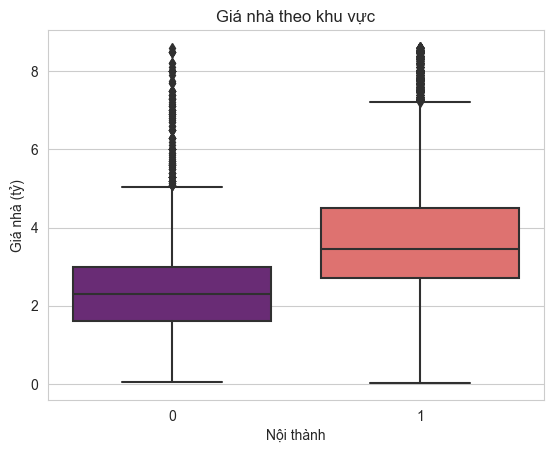

In [117]:
sns.boxplot(data=df_train_no_outlier, x='Nội thành', y='Giá', palette='magma')
plt.title('Giá nhà theo khu vực')
plt.xlabel('Nội thành')
plt.ylabel('Giá nhà (tỷ)')
plt.show()

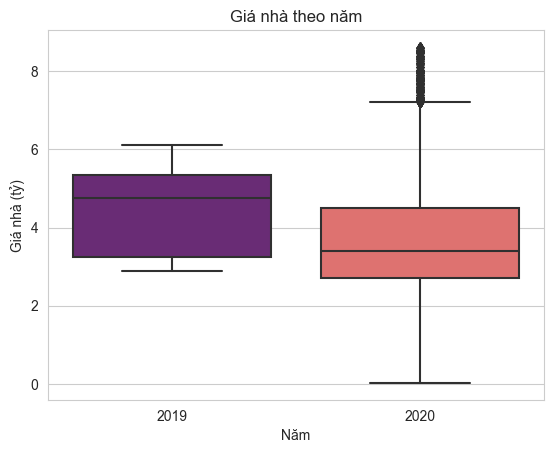

In [118]:
sns.boxplot(data=df_train_no_outlier, x='Năm', y='Giá', palette='magma')
plt.title('Giá nhà theo năm')
plt.xlabel('Năm')
plt.ylabel('Giá nhà (tỷ)')
plt.show()

# Xây dựng mô hình dự đoán giá nhà

In [119]:
X = df_train_no_outlier.copy()
y = X.pop('Giá')

In [120]:
X.drop(['Ngày', 'Giá/m2', 'Đơn vị tính'], axis=1, inplace=True)

## Baseline model

In [121]:
X.head()

Quận             Phường Loại hình nhà ở Giấy tờ pháp lý  \
7743    Quận Hà Đông   Phường Yên Nghĩa    Nhà ngõ, hẻm        Đã có sổ   
28533   Quận Ba Đình     Phường Đội Cấn    Nhà ngõ, hẻm        Đã có sổ   
18024    Quận Tây Hồ   Phường Thụy Khuê    Nhà ngõ, hẻm         Unknown   
22660  Quận Cầu Giấy   Phường Trung Hoà    Nhà ngõ, hẻm        Đã có sổ   
8654    Quận Đống Đa  Phường Trung Liệt    Nhà ngõ, hẻm        Đã có sổ   

       Số tầng  Số phòng ngủ    Diện tích  Nội thành   Năm  Tháng  
7743   Unknown             4 36.000000000          1  2020      7  
28533        4             4 35.000000000          1  2020      7  
18024  Unknown             4 55.000000000          1  2020      7  
22660        5             5 38.000000000          1  2020      7  
8654         4             4 40.000000000          1  2020      7

In [122]:
X_baseline = X.loc[:, ['Số phòng ngủ', 'Diện tích', 'Nội thành', 'Năm', 'Tháng']]

In [123]:
X_baseline.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59986 entries, 7743 to 15795
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Số phòng ngủ  59986 non-null  int32  
 1   Diện tích     59986 non-null  float64
 2   Nội thành     59986 non-null  int64  
 3   Năm           59986 non-null  int32  
 4   Tháng         59986 non-null  int32  
dtypes: float64(1), int32(3), int64(1)
memory usage: 4.1 MB


In [124]:
baseline_classifier = Classifier()
baseline_classifier.fit(X_baseline, y)

100%|██████████| 7/7 [01:34<00:00, 13.57s/it]


In [125]:
baseline_summary = baseline_classifier.summary()
baseline_summary.sort_values(by=['Score RMSE', 'Std RMSE', 'Score MAE', 'Std MAE'], ascending=True)

Score RMSE    Std RMSE   Score MAE     Std MAE
LightGBM      1.193875412 0.005856197 1.425372795 0.013990414
CatBoost      1.194452341 0.005790013 1.426749919 0.013833514
XGBoost       1.202133436 0.005737942 1.445157723 0.013803951
Random Forest 1.215559538 0.003290024 1.477595815 0.008002134
Decision Tree 1.237264182 0.004062694 1.530839162 0.010052551
KNN           1.302730549 0.008677827 1.697182188 0.022583137
Linear Model  1.396724599 0.016728453 1.951119448 0.047000578

## Encode categorical columns

### Ordinal encode

In [126]:
categorical_cols = ['Quận', 'Phường', 'Giấy tờ pháp lý', 'Loại hình nhà ở', 'Số tầng']

X_ordinal = X.copy()
for col in categorical_cols:
    X_ordinal[col] = X_ordinal[col].cat.codes

In [127]:
ordinal_encode_classifier = Classifier()
ordinal_encode_classifier.fit(X_ordinal, y)

100%|██████████| 7/7 [02:47<00:00, 23.90s/it]


In [128]:
ordinal_encode_summary = ordinal_encode_classifier.summary()
ordinal_encode_summary.sort_values(by=['Score RMSE', 'Std RMSE', 'Score MAE', 'Std MAE'], ascending=True)

Score RMSE    Std RMSE   Score MAE     Std MAE
XGBoost       1.020326491 0.008961631 1.041146460 0.018282841
LightGBM      1.031640688 0.008520493 1.064355108 0.017565600
CatBoost      1.038141503 0.006634066 1.077781791 0.013757690
Random Forest 1.061544071 0.013949685 1.127070409 0.029671266
KNN           1.123212615 0.011549279 1.261739964 0.025991873
Linear Model  1.343356789 0.014819831 1.804827089 0.039955905
Decision Tree 1.363716999 0.014818507 1.859943642 0.040475704

### Ordinal encoder + onehot encoder

In [129]:
print('Số lượng unique value trong mỗi cột:')
for col in X.select_dtypes('category'):
    print(col.ljust(37), len(X[col].unique()))

Số lượng unique value trong mỗi cột:
Quận                                  28
Phường                                284
Loại hình nhà ở                       4
Giấy tờ pháp lý                       4
Số tầng                               12


In [130]:
ordinal_cols = ['Quận', 'Phường', 'Số tầng']
onehot_cols = ['Giấy tờ pháp lý', 'Loại hình nhà ở', 'Nội thành']

In [131]:
oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')

In [132]:
X_cb = X.copy()
for col in ordinal_cols:
    X_cb[col] = X_cb[col].cat.codes

X_cb.reset_index(drop=True, inplace=True)

oh_X = pd.DataFrame(oh_encoder.fit_transform(X_cb.loc[:, onehot_cols]))
X_cb = pd.concat([X_cb, oh_X], axis=1)
X_cb.columns = X_cb.columns.astype(str)

X_cb.drop(onehot_cols, axis=1, inplace=True)

In [134]:
cb_encode_classifier = Classifier()
cb_encode_classifier.fit(X_cb, y)

100%|██████████| 7/7 [02:52<00:00, 24.60s/it]


In [135]:
cb_encode_summary = cb_encode_classifier.summary()
cb_encode_summary.sort_values(by=['Score RMSE', 'Std RMSE', 'Score MAE', 'Std MAE'], ascending=True)

Score RMSE    Std RMSE   Score MAE     Std MAE
XGBoost       1.020917518 0.010821730 1.042389689 0.022075314
LightGBM      1.031392666 0.008999342 1.063851820 0.018548854
CatBoost      1.038912752 0.006332347 1.079379804 0.013151070
Random Forest 1.061052418 0.013429359 1.126012581 0.028581899
KNN           1.108106149 0.012805391 1.228063215 0.028356517
Linear Model  1.337452507 0.015857082 1.789030656 0.042586767
Decision Tree 1.358047509 0.009053497 1.844375003 0.024558542

### Ordinal encoder + standard scale

In [136]:
scaler = StandardScaler()

In [137]:
X_scaled = pd.DataFrame(scaler.fit_transform(X_ordinal))
X_scaled.columns = X_ordinal.columns.astype(str)

In [138]:
scaled_classifier = Classifier()
scaled_classifier.fit(X_scaled, y)

100%|██████████| 7/7 [02:56<00:00, 25.15s/it]


In [139]:
scaled_summary = scaled_classifier.summary()
scaled_summary.sort_values(by=['Score RMSE', 'Std RMSE', 'Score MAE', 'Std MAE'], ascending=True)

Score RMSE    Std RMSE   Score MAE     Std MAE
XGBoost       1.020326491 0.008961631 1.041146460 0.018282841
LightGBM      1.031632146 0.009375740 1.064352789 0.019332406
CatBoost      1.038636432 0.006537811 1.078808380 0.013562147
Random Forest 1.061713302 0.013987505 1.127430787 0.029762395
KNN           1.150066031 0.011592349 1.322786258 0.026639529
Linear Model  1.343356789 0.014819831 1.804827089 0.039955905
Decision Tree 1.363519713 0.015300034 1.859420100 0.041787569

# Select XGBoost for final model

## Hyperparameter tuning

In [ ]:
def objective(trial, X=X_scaled, y=y):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 1),
        'n_estimators': trial.suggest_int('n_estimators', 2, 8000),
        'max_depth': trial.suggest_int('max_depth', 0, 20),
        'min_split_loss': trial.suggest_float('min_split_loss', 0, 20),
        'min_child_weight': trial.suggest_float('min_child_weight', 0, 20),
        'max_delta_step': trial.suggest_float('max_delta_step', 0, 10),
        'subsample': trial.suggest_float('subsample', 0.1, 1),
        'sampling_method': trial.suggest_categorical('sampling_method', ['uniform', 'gradient_based']),
        'lambda': trial.suggest_float('lambda', 0, 20),
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        'max_leaves': trial.suggest_int('max_leaves', 0, 20),
        'max_bin': trial.suggest_int('max_bin', 2, 256)
    }

    kf = KFold(n_splits=5)
    scores = []
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model = XGBRegressor(**params, random_state=42, n_jobs=-1, tree_method='gpu_hist')
        model.fit(X_train, y_train, verbose=False)

        y_pred = model.predict(X_val)
        test_score = mean_squared_error(y_val, y_pred, squared=False)
        scores.append(test_score)
    
    return np.mean(scores)

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-07-13 07:00:02,210] A new study created in memory with name: no-name-5de976e5-bce4-4fd0-a123-788a45a79b1c
[I 2023-07-13 07:02:05,356] Trial 0 finished with value: 0.905041352516631 and parameters: {'learning_rate': 0.7657335367112077, 'n_estimators': 7378, 'max_depth': 15, 'min_split_loss': 2.958206039217528, 'min_child_weight': 7.580447635881981, 'max_delta_step': 5.647863754928668, 'subsample': 0.8072483305725084, 'sampling_method': 'uniform', 'lambda': 19.701628001392397, 'grow_policy': 'depthwise', 'max_leaves': 10, 'max_bin': 67}. Best is trial 0 with value: 0.905041352516631.
[I 2023-07-13 07:03:34,615] Trial 1 finished with value: 0.9182928843369556 and parameters: {'learning_rate': 0.7902764505674427, 'n_estimators': 4841, 'max_depth': 9, 'min_split_loss': 4.552904689865807, 'min_child_weight': 13.780428625412739, 'max_delta_step': 0.5527740392772806, 'subsample': 0.574060997975983, 'sampling_method': 'uniform', 'lambda': 17.603454181421018, 'grow_policy': 'lossguide', 

Number of finished trials: 200
Best trial: {'learning_rate': 0.06081051648356832, 'n_estimators': 6671, 'max_depth': 19, 'min_split_loss': 0.7539971777999263, 'min_child_weight': 4.987377231026663, 'max_delta_step': 6.352391656372724, 'subsample': 0.869191881805553, 'sampling_method': 'uniform', 'lambda': 1.7402122812931264, 'grow_policy': 'lossguide', 'max_leaves': 18, 'max_bin': 142}


In [140]:
params = {'learning_rate': 0.06081051648356832, 'n_estimators': 6671, 'max_depth': 19, 'min_split_loss': 0.7539971777999263, 'min_child_weight': 4.987377231026663, 'max_delta_step': 6.352391656372724, 'subsample': 0.869191881805553, 'sampling_method': 'uniform', 'lambda': 1.7402122812931264, 'grow_policy': 'lossguide', 'max_leaves': 18, 'max_bin': 142}

In [141]:
model = XGBRegressor(**params, random_state=42, n_jobs=-1, tree_method='gpu_hist')
model.fit(X_scaled, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy='lossguide',
             importance_type=None, interaction_constraints=None,
             lambda=1.7402122812931264, learning_rate=0.06081051648356832,
             max_bin=142, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=6.352391656372724, max_depth=19, max_leaves=18,
             min_child_weight=4.987377231026663,
             min_split_loss=0.7539971777999263, missing=nan,
             monotone_constraints=None, n_estimators=6671, n_jobs=-1,
             num_parallel_tree=None, ...)

## Processing test-set

In [142]:
X_test = df_test.copy()
y_test = X_test.pop('Giá')

In [143]:
X_test.drop(['Ngày', 'Giá/m2', 'Đơn vị tính'], axis=1, inplace=True)

In [144]:
X_ordinal_test = X_test.copy()
for col in categorical_cols:
    X_ordinal_test[col] = X_ordinal_test[col].cat.codes

In [145]:
X_scaled_test = pd.DataFrame(scaler.transform(X_ordinal_test))
X_scaled_test.columns = X_ordinal_test.columns.astype(str)

## Testing

In [148]:
y_pred = model.predict(X_scaled_test)
print('RMSE score:', mean_squared_error(y_test, y_pred, squared=False))
print('MAE score:', mean_absolute_error(y_test, y_pred))

RMSE score: 73.46327431674595
MAE score: 3.035027986746591


# Summary

In [156]:
df_pred = pd.DataFrame({
    'y_pred': y_pred,
    'y_test': y_test,
    'error': abs(y_pred - y_test)
})

In [157]:
df_pred.head()

y_pred      y_test       error
22213 5.403500080 8.999760000 3.596259920
55014 3.664644480 5.200000000 1.535355520
52852 4.333394527 4.500230000 0.166835473
81138 5.083576202 5.499900000 0.416323798
50661 0.990600646 1.410000000 0.419399354

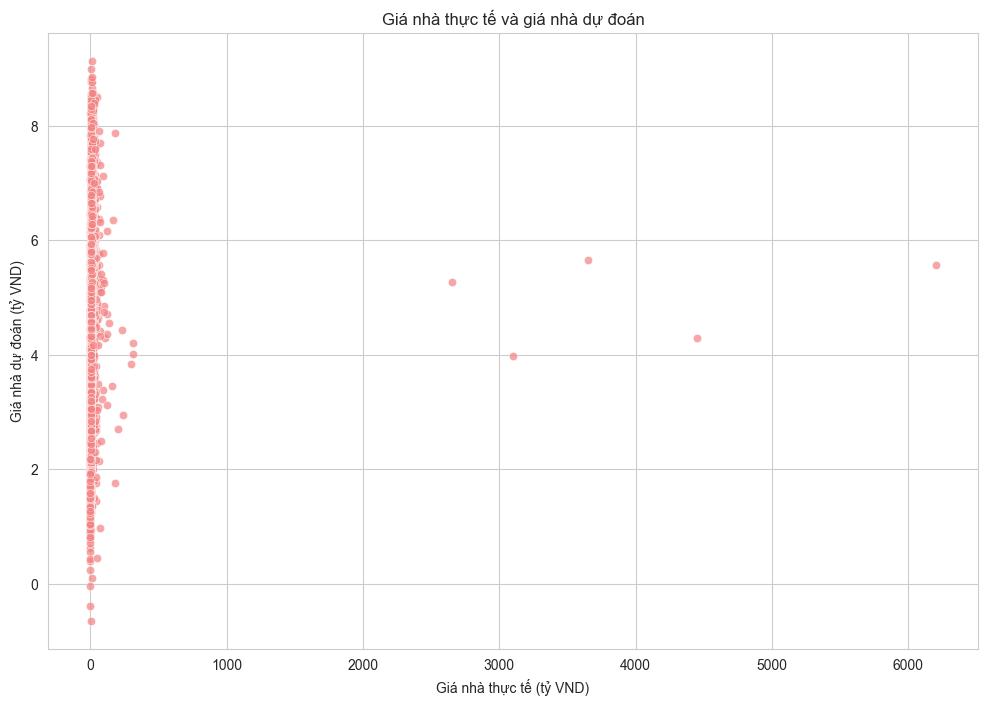

In [250]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_pred, x='y_test', y='y_pred', alpha=0.7, color='#F38181')
plt.title('Giá nhà thực tế và giá nhà dự đoán')
plt.xlabel('Giá nhà thực tế (tỷ VND)')
plt.ylabel('Giá nhà dự đoán (tỷ VND)')
plt.show()

**Nhận xét**: tập test có một vài outlier mô hình không dự đoán được giá

In [171]:
df_pred.sort_values(by='error', ascending=False).head(10)

y_pred         y_test          error
23803 5.556128502 6200.000000000 6194.443871498
51823 4.289775372 4448.000000000 4443.710224628
1574  5.644052029 3649.998860000 3644.354807971
73597 3.976968527 3099.999969000 3096.023000473
1583  5.265932083 2649.998520000 2644.732587917
82116 4.010414124  309.997800000  305.987385876
14827 4.195895195  310.000500000  305.804604805
16393 3.832955360  299.999999988  296.167044628
63827 2.945009708  239.998500000  237.053490292
12489 4.425043583  229.999999968  225.574956385

In [172]:
iqr = df_pred['y_test'].quantile(0.75) - df_pred['y_test'].quantile(0.25)
upper_bound = df_pred['y_test'].quantile(0.75) + 1.5 * iqr
lower_bound = df_pred['y_test'].quantile(0.25) - 1.5 * iqr

df_pred_no_outlier = df_pred[(df_pred['y_test'] < upper_bound) & (df_pred['y_test'] > lower_bound)]

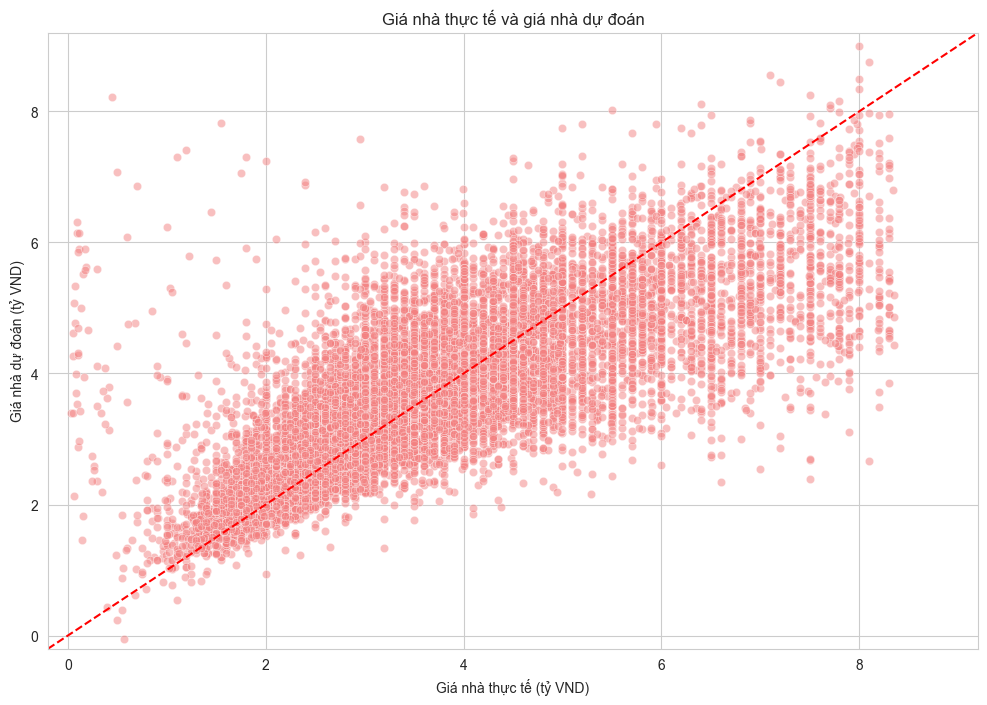

In [251]:
lim = (-0.2, 9.2)

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_pred_no_outlier, x='y_test', y='y_pred', alpha=0.5, color='#F38181')
plt.xlim(*lim)
plt.ylim(*lim)
plt.plot(lim, lim, color='red', linestyle='--')
plt.title('Giá nhà thực tế và giá nhà dự đoán')
plt.xlabel('Giá nhà thực tế (tỷ VND)')
plt.ylabel('Giá nhà dự đoán (tỷ VND)')
plt.show()

In [258]:
def plot_pred_actual(col, col_wrap=4):
    lim = (-0.2, 9.2)
    g = sns.relplot(data=df_pred_no_outlier, x='y_test', y='y_pred', alpha=0.7, color='#F38181', col=X_test[col], kind='scatter', col_wrap=col_wrap)
    for ax in g.axes.flat:
        ax.set_xlim(*lim)
        ax.set_ylim(*lim)
        ax.plot(lim, lim, color='red', linestyle='--')
    g.fig.suptitle(f'Giá nhà thực tế và giá nhà dự đoán theo {col}', y=1.05)
    g.set_axis_labels('Giá nhà thực tế (tỷ VND)', 'Giá nhà dự đoán (tỷ VND)')
    plt.show()

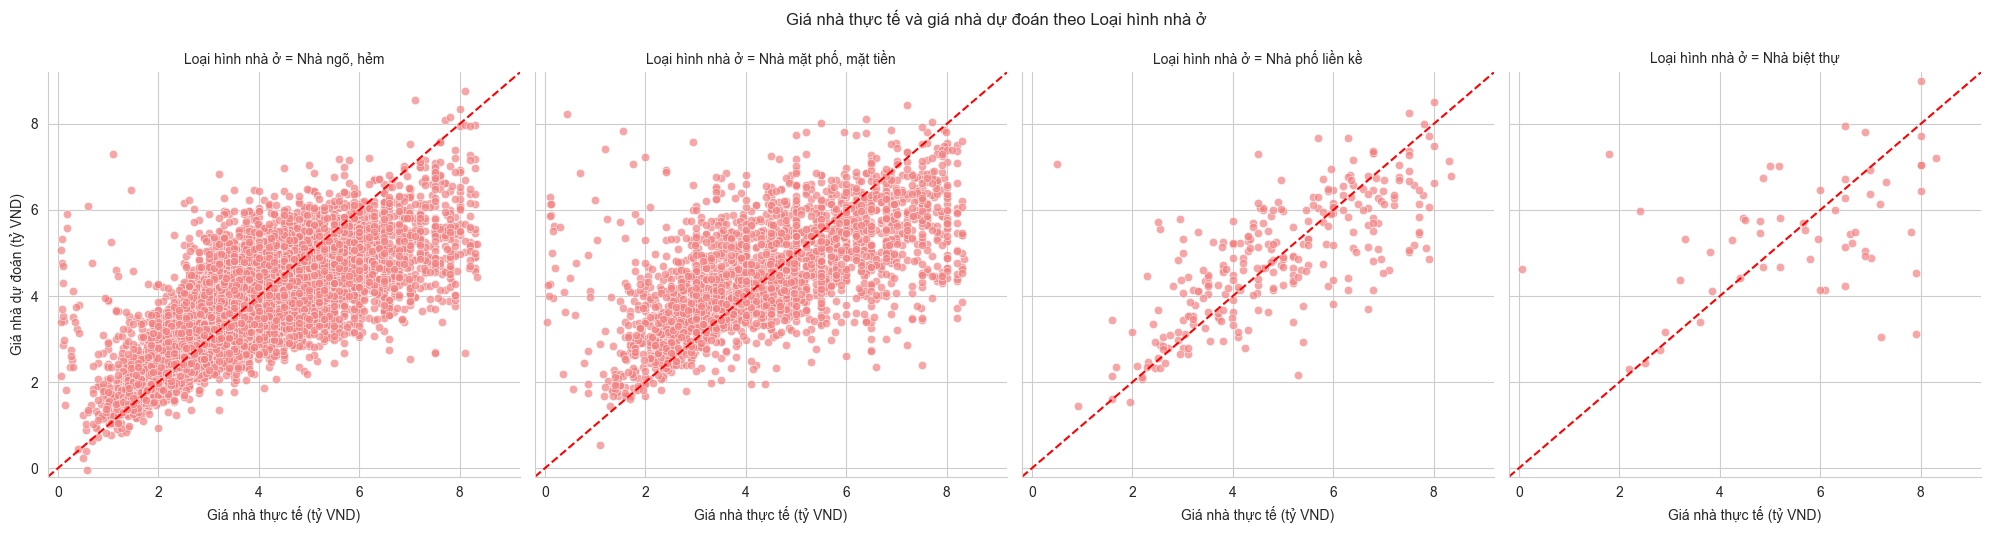

In [259]:
plot_pred_actual('Loại hình nhà ở')

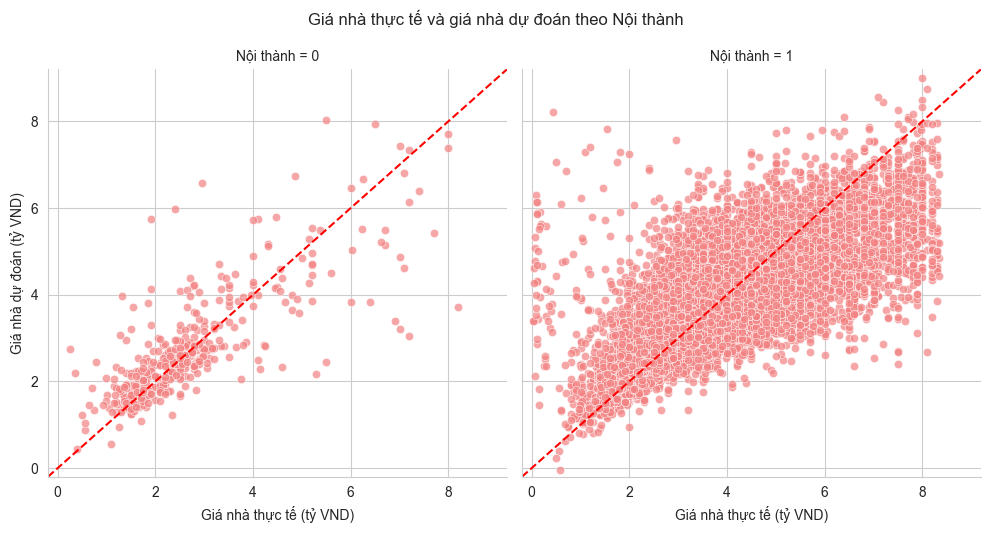

In [260]:
plot_pred_actual('Nội thành', col_wrap=2)

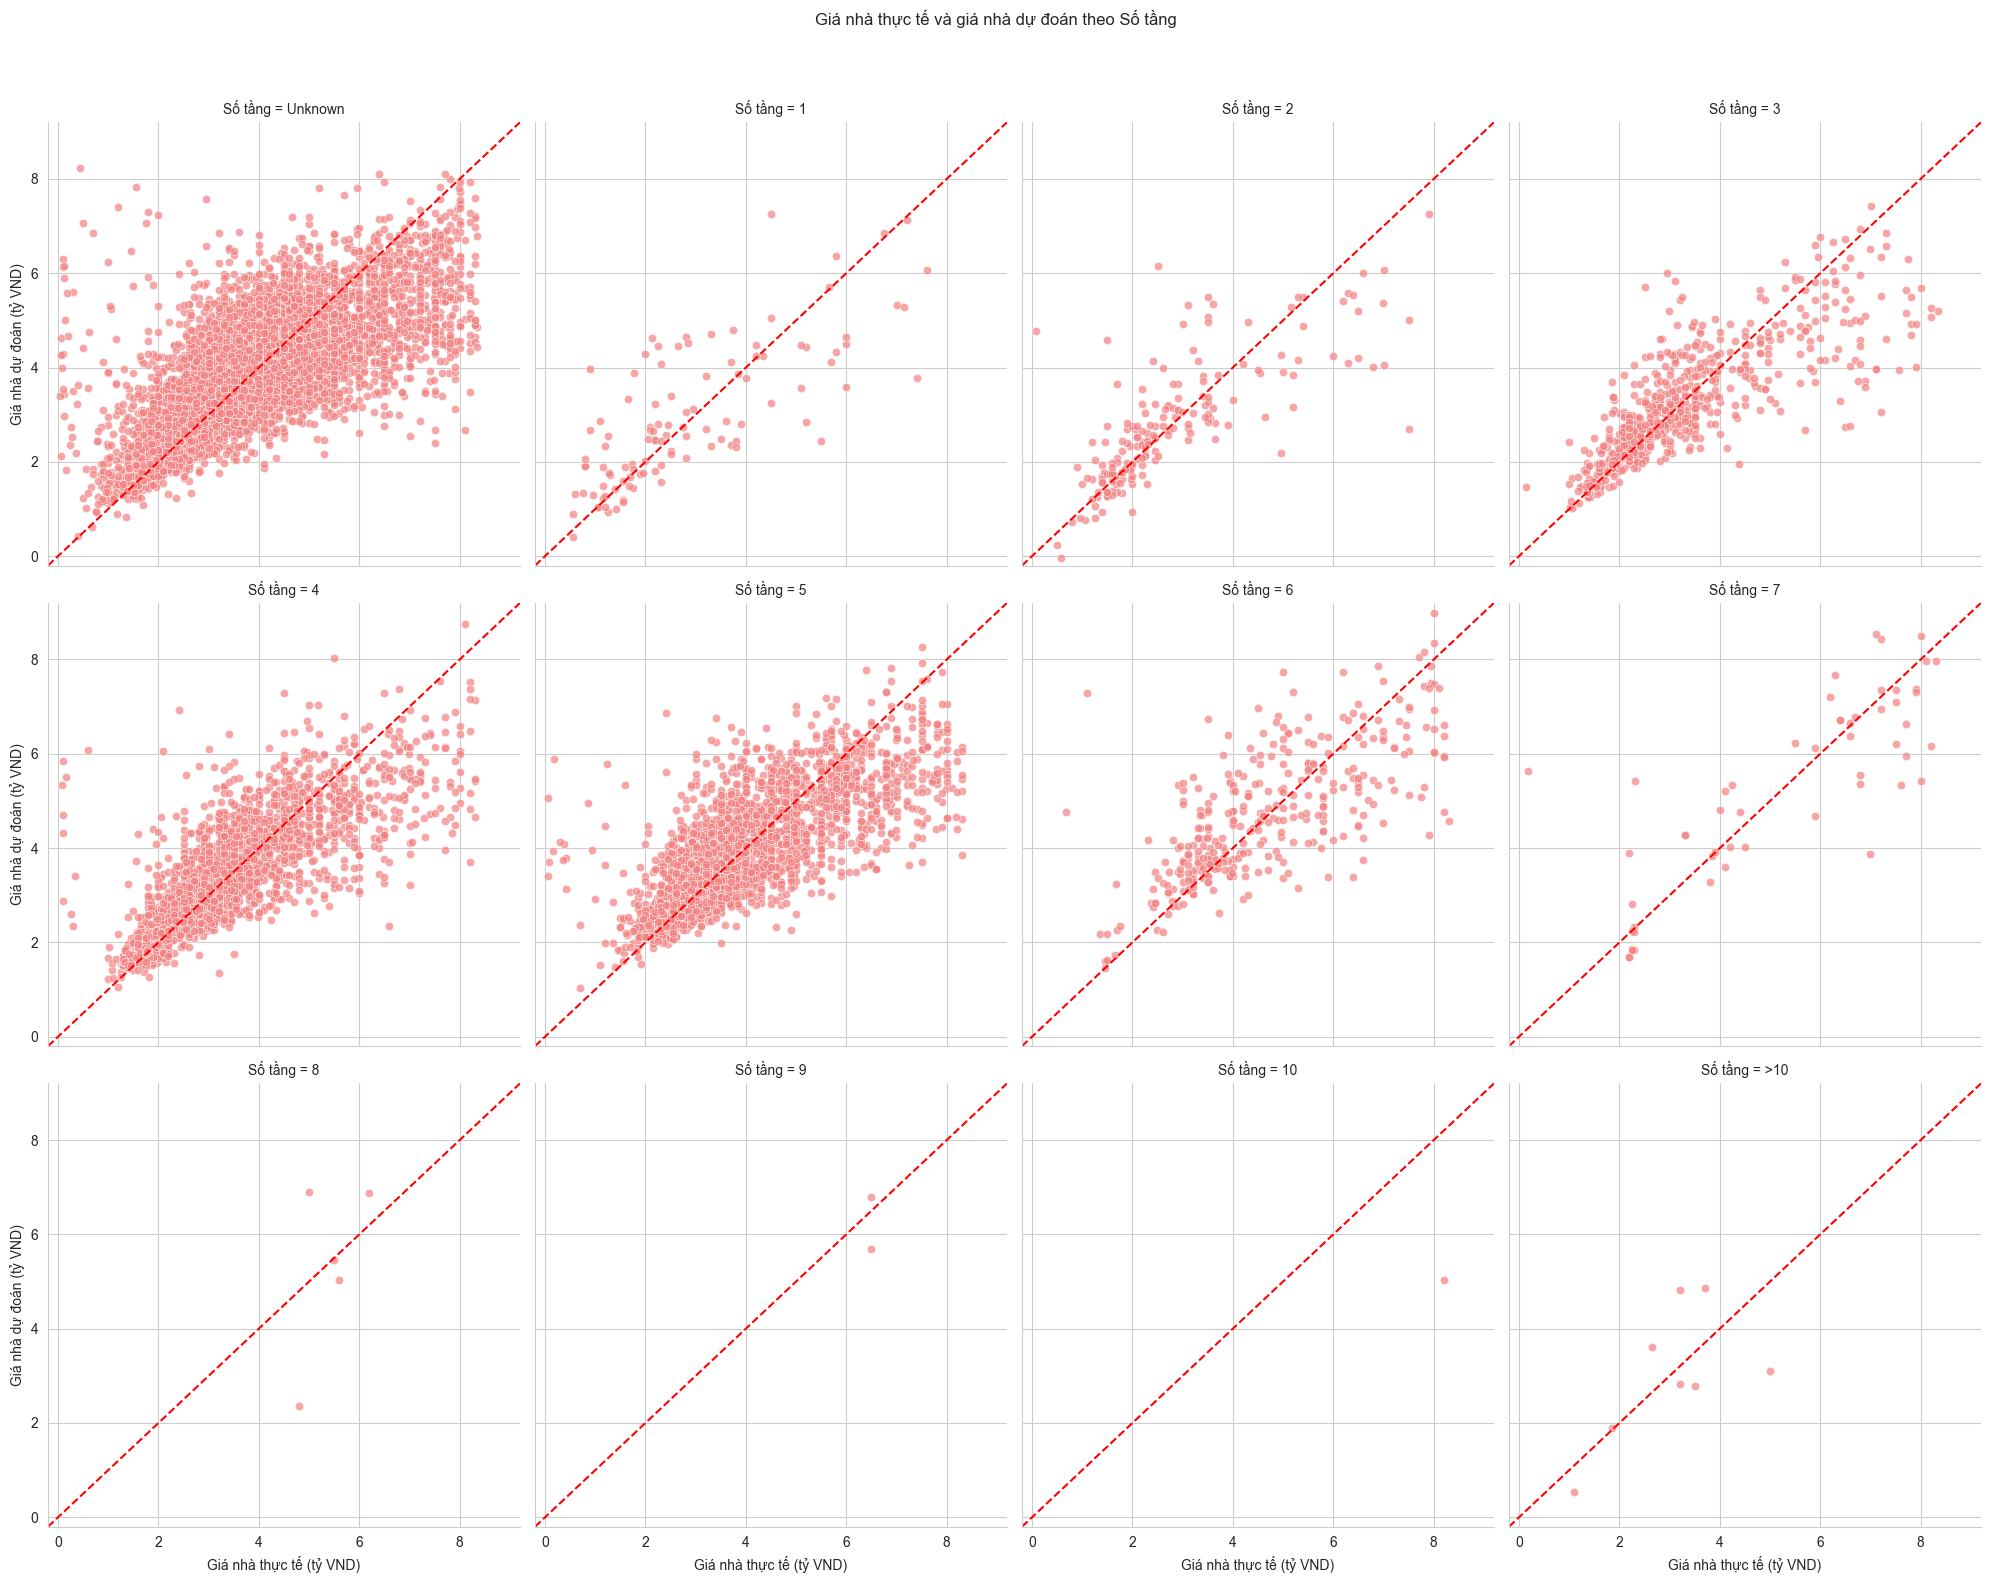

In [261]:
plot_pred_actual('Số tầng')

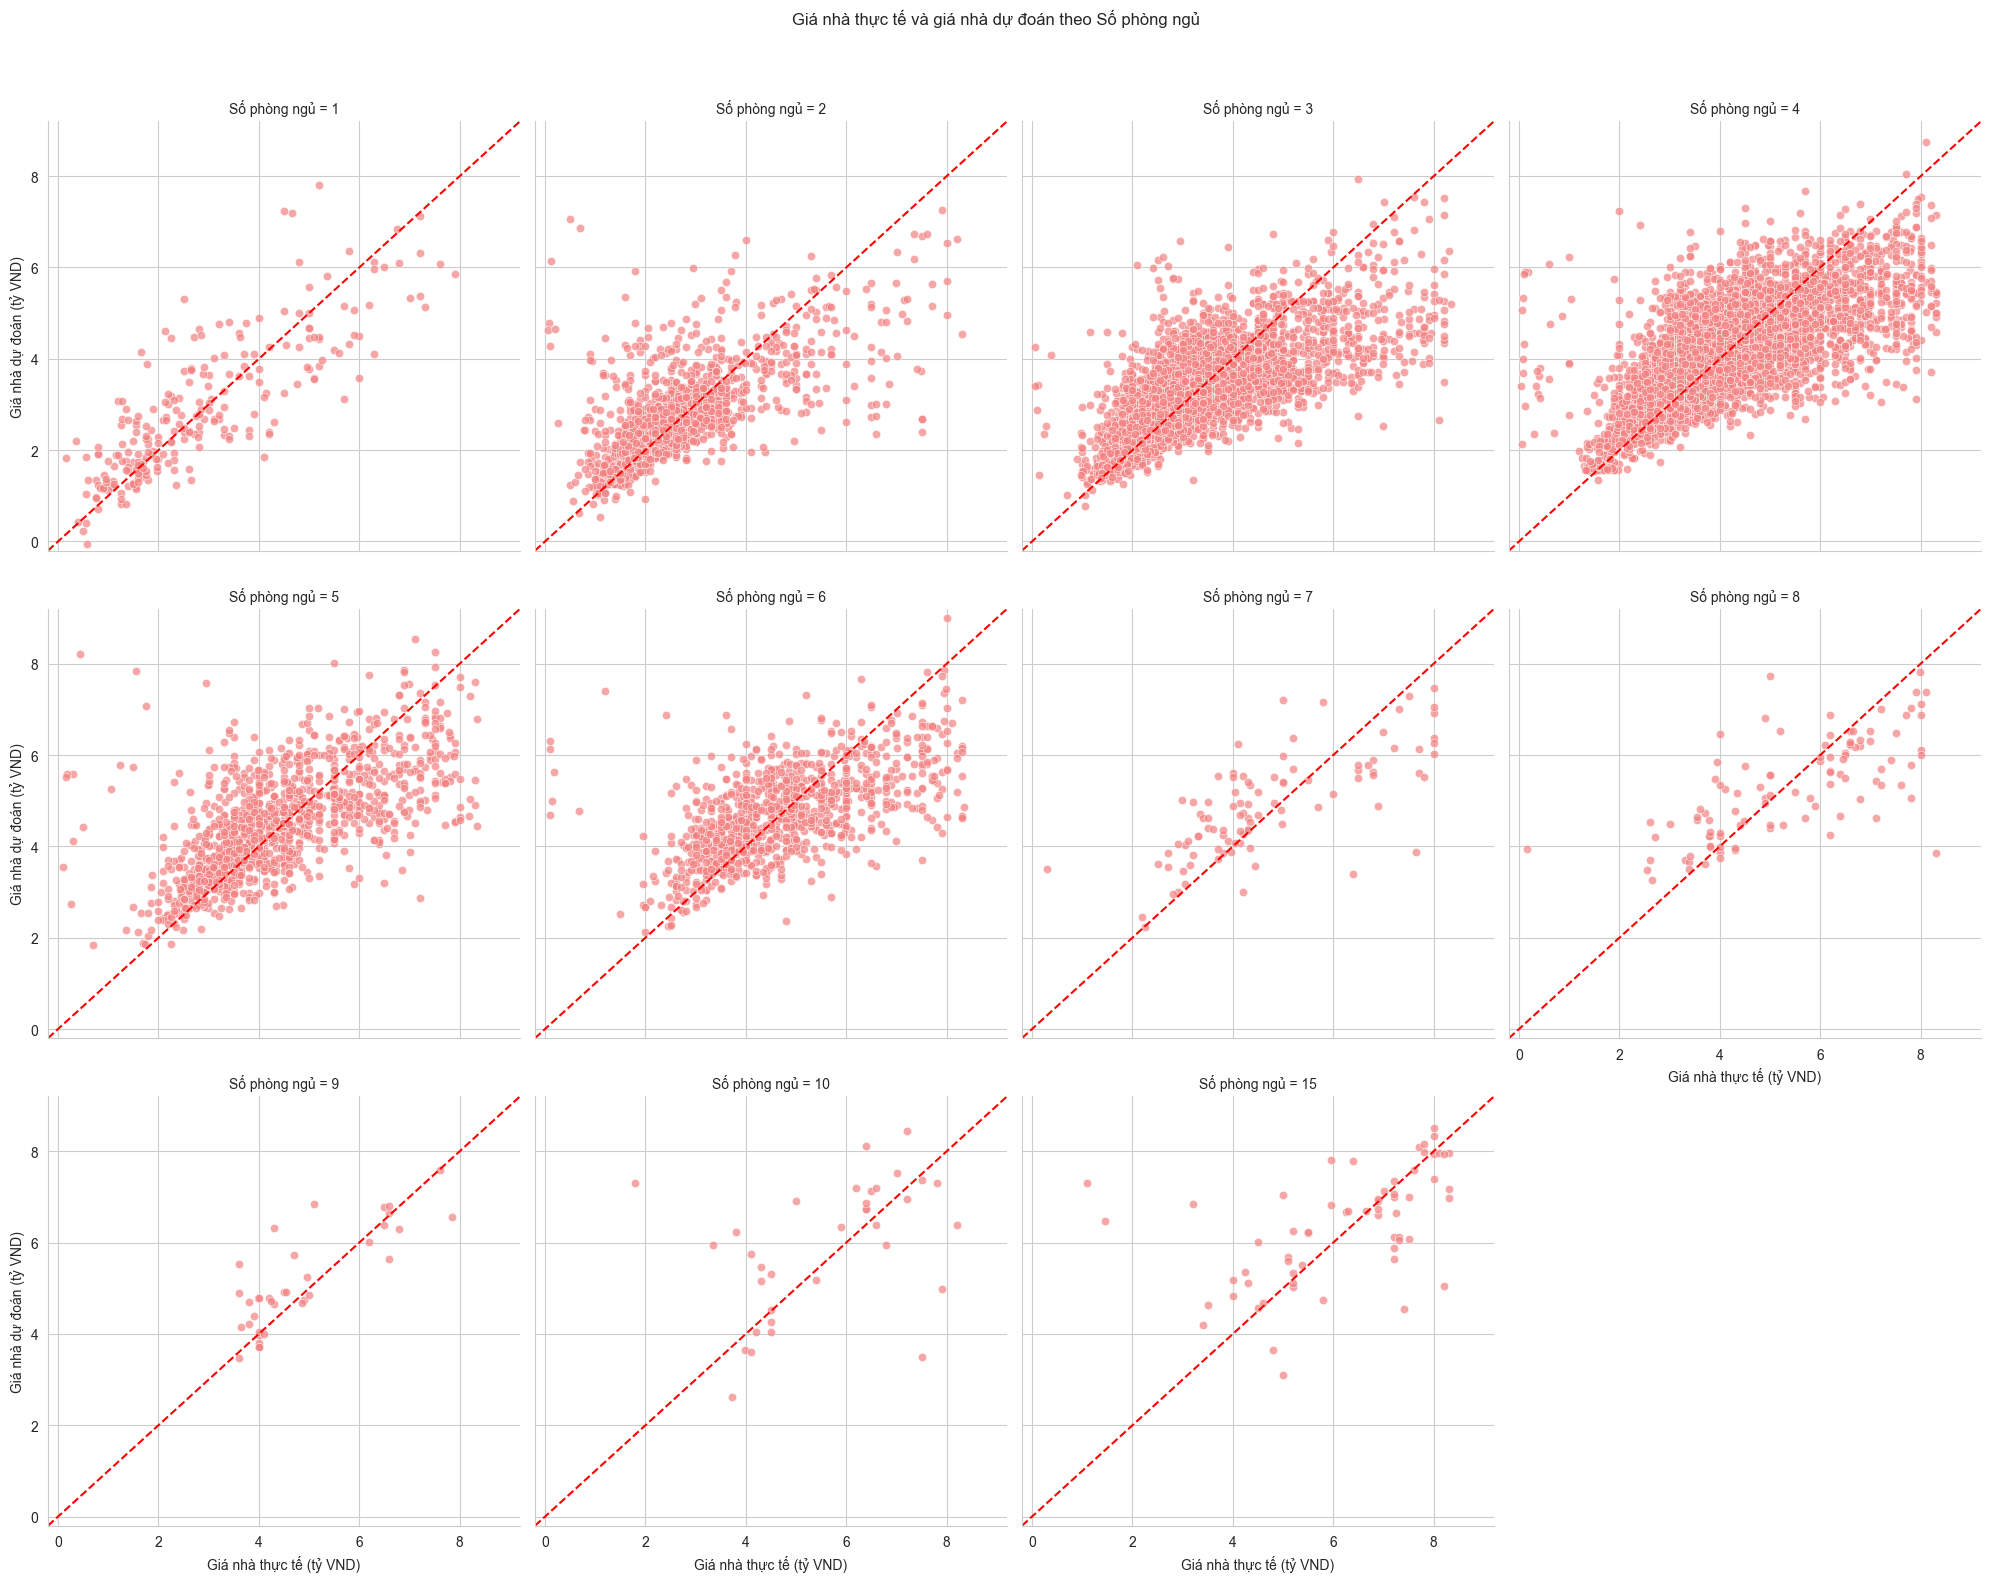

In [262]:
plot_pred_actual('Số phòng ngủ')

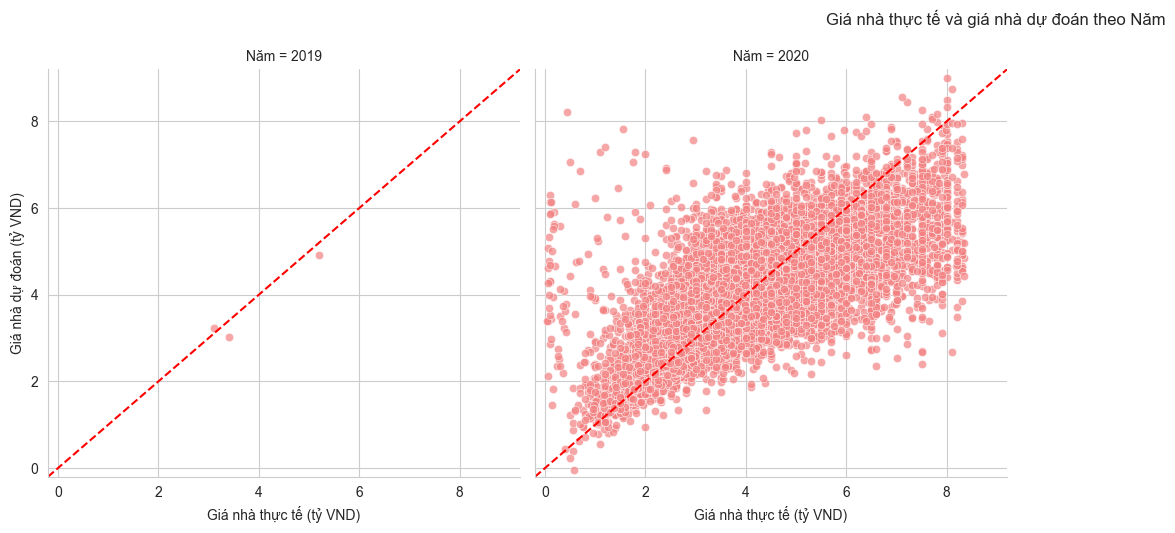

In [264]:
plot_pred_actual('Năm')

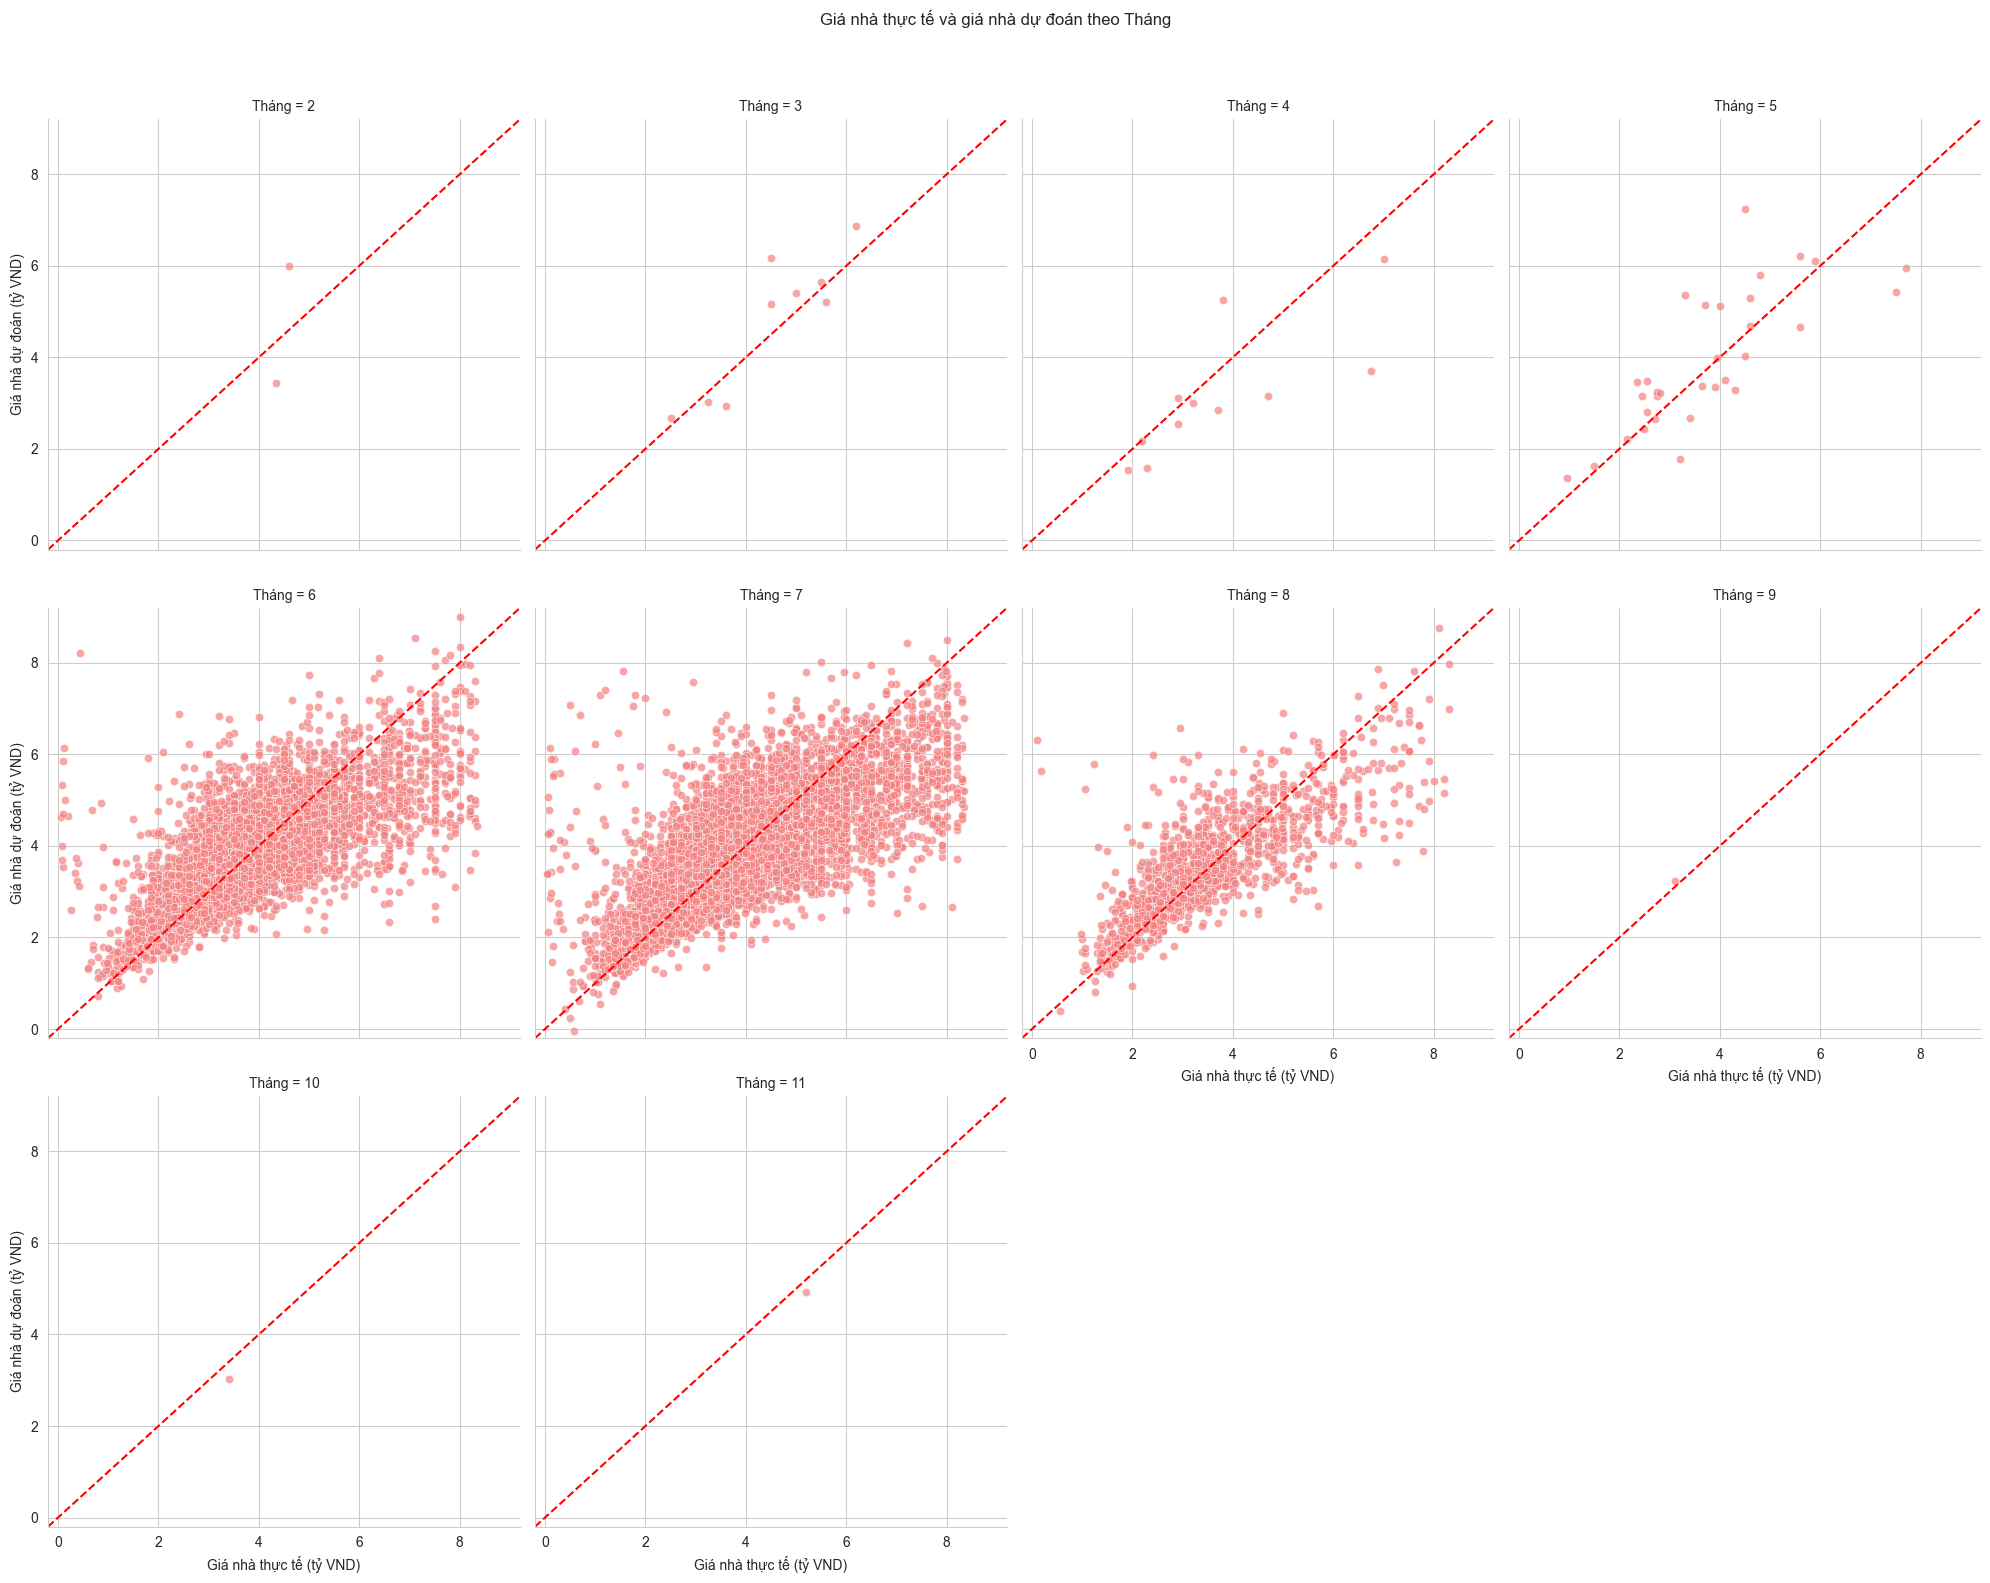

In [263]:
plot_pred_actual('Tháng')